In [1]:
import requests
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import math
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from conf.conf import logging, settings
from sklearn import preprocessing,model_selection,linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import catboost as ctb
from nltk.stem.porter import PorterStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from scipy.sparse import csr_matrix, hstack

import warnings
warnings.filterwarnings("ignore")

In [2]:
df1 = pd.read_csv('catalogue/Декорации настенные.csv')
df2 = pd.read_csv('catalogue/Автоэлектроника и навигация.csv')
df3 = pd.read_csv('catalogue/Чертежные принадлежности.csv')
df1 = df1.rename(columns={'barnd':'brand'})
df2 = df2.rename(columns={'barnd':'brand'})
df3 = df3.rename(columns={'barnd':'brand'})

In [3]:
df1 = df1.drop(['price','discount'],axis=1)
df2 = df2.drop(['price','discount'],axis=1)
df3 = df3.drop(['price','discount'],axis=1)

In [4]:
def get_clean_data(df:pd.DataFrame):
    for column in df.columns:
        if df[column].isnull().sum()/len(df) >= 0.5:
            df = df.drop(column,axis=1)
    return df
    

In [5]:
df1 = get_clean_data(df1)
df2 = get_clean_data(df2)
df3 = get_clean_data(df3)

In [6]:
def preprocess_num_col(NUMERIC_COLUMNS,df):
    for column in NUMERIC_COLUMNS:
        df[column] = df[column].apply(lambda value: re.sub('\D', '', str(value)))
        df[column] = df[column].replace('',0)
        df[column] = df[column].apply(lambda value: int(value))
    return df

In [7]:
NUMERIC_COLUMNS1=['Высота упаковки', 'Длина упаковки',
       'Ширина упаковки',]
NUMERIC_COLUMNS2=['Вес товара с упаковкой (г)',
       'Длина упаковки', 'Высота упаковки', 'Ширина упаковки']
NUMERIC_COLUMNS3=['Высота упаковки', 'Длина упаковки', 'Ширина упаковки', 'Количество предметов в упаковке',
       'Вес товара с упаковкой (г)']
TEXT_COLUMNS1 = ['Описание']
TEXT_COLUMNS2 = ['Описание']
TEXT_COLUMNS3 = ['Описание']
NOT_INCLUDE = ['id','dicsounted Price','Высота упаковки',
 'Длина упаковки','Описание','Высота упаковки','Ширина упаковки','Вес товара с упаковкой (г)','Количество предметов в упаковке','SKU','name']
CATEGORICAL_COLUMNS1 = [x for x in df1.columns if x not in NOT_INCLUDE]
CATEGORICAL_COLUMNS2 = [x for x in df2.columns if x not in NOT_INCLUDE]
CATEGORICAL_COLUMNS3 = [x for x in df3.columns if x not in NOT_INCLUDE]

In [8]:
df1 = preprocess_num_col(NUMERIC_COLUMNS1,df1)
df2 = preprocess_num_col(NUMERIC_COLUMNS2,df2)
df3 = preprocess_num_col(NUMERIC_COLUMNS3,df3)

In [9]:
def data_review(data:pd.DataFrame)->None:
    '''
    Выводит общую информацию о датафрейме.
    '''
    print('Общая информация о датафрейме:')
    display(data.info())
    print('='*60)
    print('Описание датафрейма')
    display(data.describe())
    print('='*60)
    print('Первые 5 строчек датафрейма:')
    display(data.head())
    print('='*60)
    print('Количество строк-дубликатов:', data.duplicated().sum())
    print('='*60)

In [10]:
df1['id'] = [str(x) for x in df1['id']]
df2['id'] = [str(x) for x in df2['id']]
df3['id'] = [str(x) for x in df3['id']]
data_review(df1)


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   4756 non-null   object
 1   Высота упаковки      4756 non-null   int64 
 2   Длина упаковки       4756 non-null   int64 
 3   Тип подарка          4508 non-null   object
 4   Страна производства  4737 non-null   object
 5   Повод                4662 non-null   object
 6   Комната назначения   4756 non-null   object
 7   Назначение подарка   4634 non-null   object
 8   Хрупкость            3888 non-null   object
 9   Материал изделия     4717 non-null   object
 10  Ширина упаковки      4756 non-null   int64 
 11  Тип крепления        4423 non-null   object
 12  Описание             4756 non-null   object
 13  name                 4756 non-null   object
 14  dicsounted Price     4756 non-null   int64 
 15  brand                475

None

Описание датафрейма


,Высота упаковки,Длина упаковки,Ширина упаковки,dicsounted Price
count,4756.000000,4756.000000,4756.000000,4756.000000
mean,16.482338,35.128049,36.627628,1991.915896
std,18.978041,22.090003,17.315016,4490.938768
min,0.000000,1.000000,0.000000,99.000000
25%,5.000000,13.000000,25.000000,1029.000000
50%,5.000000,34.000000,34.000000,1449.000000
75%,28.000000,54.000000,50.000000,1764.000000
max,110.000000,112.000000,285.000000,250536.000000


Первые 5 строчек датафрейма:


,id,Высота упаковки,Длина упаковки,Тип подарка,Страна производства,Повод,Комната назначения,Назначение подарка,Хрупкость,Материал изделия,Ширина упаковки,Тип крепления,Описание,name,dicsounted Price,brand
0,111152399,10,29,Декор настенный; интерьерное украшение; Картин...,Россия,День Рождения; Новоселье; Годовщина,спальня; гостиная; детская,для ребенка; подруге; другу,Не хрупкий надёжно упакован,Дерево; Березовая фанера,38,Дистанционные держатели; Саморезы и дюбеля; Ге...,Подложка для крепления карты мира из дерева 16...,"Подложка для карты мира из дерева, пазлы детск...",920,DECOR DOME
1,111318828,5,42,декорация настенная; интерьерный; декоративный,Россия,день рождения; новый год; 8 марта,спальня; гостиная; детская,для ребенка; папе; маме,Не хрупкий надёжно упакован,дерево,32,Стена/дюбель/крюк; двусторонняя клейкая лента,КОМПЛЕКТАЦИЯ: Карта мира из дерева 160х85 см. ...,Карта мира настенная 160х85 деревянная для дет...,1056,DECOR DOME
2,153744884,10,40,декор на стену; панно на стену; наклейки и декор,Россия,день рождения; без повода; юбилей,декор для комнаты; для дома Декор; декор для к...,в гостиную; в спальню; в детскую,хрупкое,дерево; Натуральное дерево; Дерево (массив сосны),36,скрытое; Настенная; навесная,Интерьерные деревянные полки настенные в стиле...,Декор для дома на стену,2370,ekoPolka
3,111319282,5,42,декорация настенная; интерьерный; декоративный,Россия,день рождения; новый год; 8 марта,спальня; гостиная; детская,для любимой; друзям; сыну,Не хрупкий надёжно упакован,дерево,32,Стена/дюбель/крюк; двусторонняя клейкая лента,КОМПЛЕКТАЦИЯ: Карта мира из дерева 160х85 см. ...,Карта мира настенная 160х85 деревянная для дет...,948,DECOR DOME
4,74512666,5,35,декорации настенные; Карта мира географическая...,Россия,новый год; 8 марта; 23 Фeврaля,спальня; гостиная; детская,для ребенка; для любимого мужа; Для любого случая,Не хрупкий надёжно упакован,дерево,24,двухсторонняя клейкая лента,Дополнительная комплектация к карте мира из де...,Дополнительная комплектация настенная к карте ...,532,DECOR DOME


Количество строк-дубликатов: 1089


In [11]:
data_review(df2)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          4217 non-null   object
 1   Модель                      3081 non-null   object
 2   Страна производства         3937 non-null   object
 3   Вес товара с упаковкой (г)  4217 non-null   int64 
 4   Длина упаковки              4217 non-null   int64 
 5   Высота упаковки             4217 non-null   int64 
 6   Ширина упаковки             4217 non-null   int64 
 7   Описание                    4217 non-null   object
 8   name                        4217 non-null   object
 9   dicsounted Price            4217 non-null   int64 
 10  brand                       4154 non-null   object
dtypes: int64(5), object(6)
memory usage: 362.5+ KB


None

Описание датафрейма


,Вес товара с упаковкой (г),Длина упаковки,Высота упаковки,Ширина упаковки,dicsounted Price
count,4217.000000,4217.000000,4217.000000,4217.000000,4217.000000
mean,528.588096,23.017074,12.764050,17.099597,7431.863647
std,943.225064,18.823577,10.754199,10.503458,12194.570962
min,0.000000,0.000000,0.000000,0.000000,107.000000
25%,0.000000,10.000000,6.000000,10.000000,800.000000
50%,100.000000,19.000000,10.000000,15.000000,2100.000000
75%,470.000000,33.000000,19.000000,25.000000,6426.000000
max,4300.000000,333.000000,195.000000,135.000000,123607.000000


Первые 5 строчек датафрейма:


,id,Модель,Страна производства,Вес товара с упаковкой (г),Длина упаковки,Высота упаковки,Ширина упаковки,Описание,name,dicsounted Price,brand
0,150787974,Starline A93 A63 A96 A39; Старлайн А93 А63 А96...,Россия,11,8,2,5,Крышка батарейного отсека брелка StarLine A93 ...,Крышка пульта Starline A93 A63 A96 A39,132,ChariDari
1,63109022,i20,Китай,110,115,55,19,Камера заднего вида с плафоном подсветки номер...,Камера заднего вида Hyundai i20 PB с 2008г по ...,347,MyDop
2,60214339,Starline A93; Старлайн,Китай,10,1,6,5,Крышка батарейного отсека StarLine A93/A63 так...,Крышка для брелка Старлайн А93,148,AvtoCase
3,145638714,NaN,NaN,0,6,6,1,Крышка батарейного отсека для брелка Старлайн ...,Крышка батарейного отсека для брелка Старлайн ...,142,NaN
4,113503982,NaN,Китай,0,11,6,15,Данный прибор позволяет конвертировать напряже...,Инвертор автомобильный преобразователь 24-12,756,DND


Количество строк-дубликатов: 78


In [12]:
data_review(df3)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               3580 non-null   object
 1   Высота упаковки                  3580 non-null   int64 
 2   Длина упаковки                   3580 non-null   int64 
 3   Ширина упаковки                  3580 non-null   int64 
 4   Количество предметов в упаковке  3580 non-null   int64 
 5   Назначение                       2542 non-null   object
 6   Вес товара с упаковкой (г)       3580 non-null   int64 
 7   Страна производства              3127 non-null   object
 8   Описание                         3580 non-null   object
 9   name                             3580 non-null   object
 10  dicsounted Price                 3580 non-null   int64 
 11  brand                            3526 non-null   object
dtypes: 

None

Описание датафрейма


,Высота упаковки,Длина упаковки,Ширина упаковки,Количество предметов в упаковке,Вес товара с упаковкой (г),dicsounted Price
count,3580.000000,3580.000000,3580.000000,3.580000e+03,3580.000000,3580.000000
mean,10.273743,14.375698,10.062570,3.590420e+03,90.481006,473.382682
std,12.625096,15.543409,8.485182,1.247722e+05,296.246767,1079.150458
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,63.000000
25%,1.000000,2.000000,5.000000,0.000000e+00,0.000000,155.000000
50%,4.000000,14.000000,9.000000,1.000000e+00,20.000000,241.000000
75%,20.000000,21.000000,13.000000,1.200000e+01,81.000000,432.000000
max,198.000000,297.000000,117.000000,7.272612e+06,7956.000000,25338.000000


Первые 5 строчек датафрейма:


,id,Высота упаковки,Длина упаковки,Ширина упаковки,Количество предметов в упаковке,Назначение,Вес товара с упаковкой (г),Страна производства,Описание,name,dicsounted Price,brand
0,140631388,21,5,1,6,для рисования; для раскрашивания; для детей,40,Китай,"Набор цветных карандашей, 6 цветов, пластиковы...","Карандаши цветные, 6 цветов, для рисования, пл...",81,SILWERHOF
1,111492083,1,33,3,1,NaN,31,Китай,"Линейка - измерительный инструмент, который пр...",Линейка,170,TUNDRA
2,65192626,3,20,22,12,Для рисования; для детей; в школу,100,Россия,Карандаши цветные 12цветов Каляка-Маляка изгот...,Карандаши цветные 12цв,204,Каляка-Маляка
3,146456945,4,9,6,0,NaN,0,NaN,"Лазер с лучом ""Линия"" 650 нм 5 МВт 3-5В красно...","Лазерный модуль с лучом ""Линия"" 650 нм 5 МВт 3-5В",450,LB Group
4,14195761,1,14,17,0,школа,29,Россия,Транспортир школьный представляет собой устрой...,Транспортир,126,ErichKrause


Количество строк-дубликатов: 18


In [13]:
def cat_graph(df,cat_call)->None:
    '''
    Строит графики для катергориальных признаков
    '''
    for val in df.columns:
        if len(df[val].unique()) < 20:
            if val in cat_call :
                plt.figure(figsize=(20, 16))
                sns.barplot(data=df, x=val, y='dicsounted Price',palette='pastel')
                plt.xticks(rotation=90)
                plt.title(val, fontsize=12)
                plt.grid(True, axis='y')
                plt.show()
                print('\n')
    else:
            for val in df.columns:
                if len(df[val].unique()) > 20 and val in cat_call:
                    anc = dict(df[val].value_counts()[:10]).keys()
                    df_cut = df[df[val].isin(anc)]
                    plt.figure(figsize=(20, 16))
                    sns.barplot(data=df_cut, x=val, y='dicsounted Price',palette='pastel')
                    plt.xticks(rotation=90)
                    plt.title(val, fontsize=12)
                    plt.grid(True, axis='y')
                    plt.show()
                    print('\n')

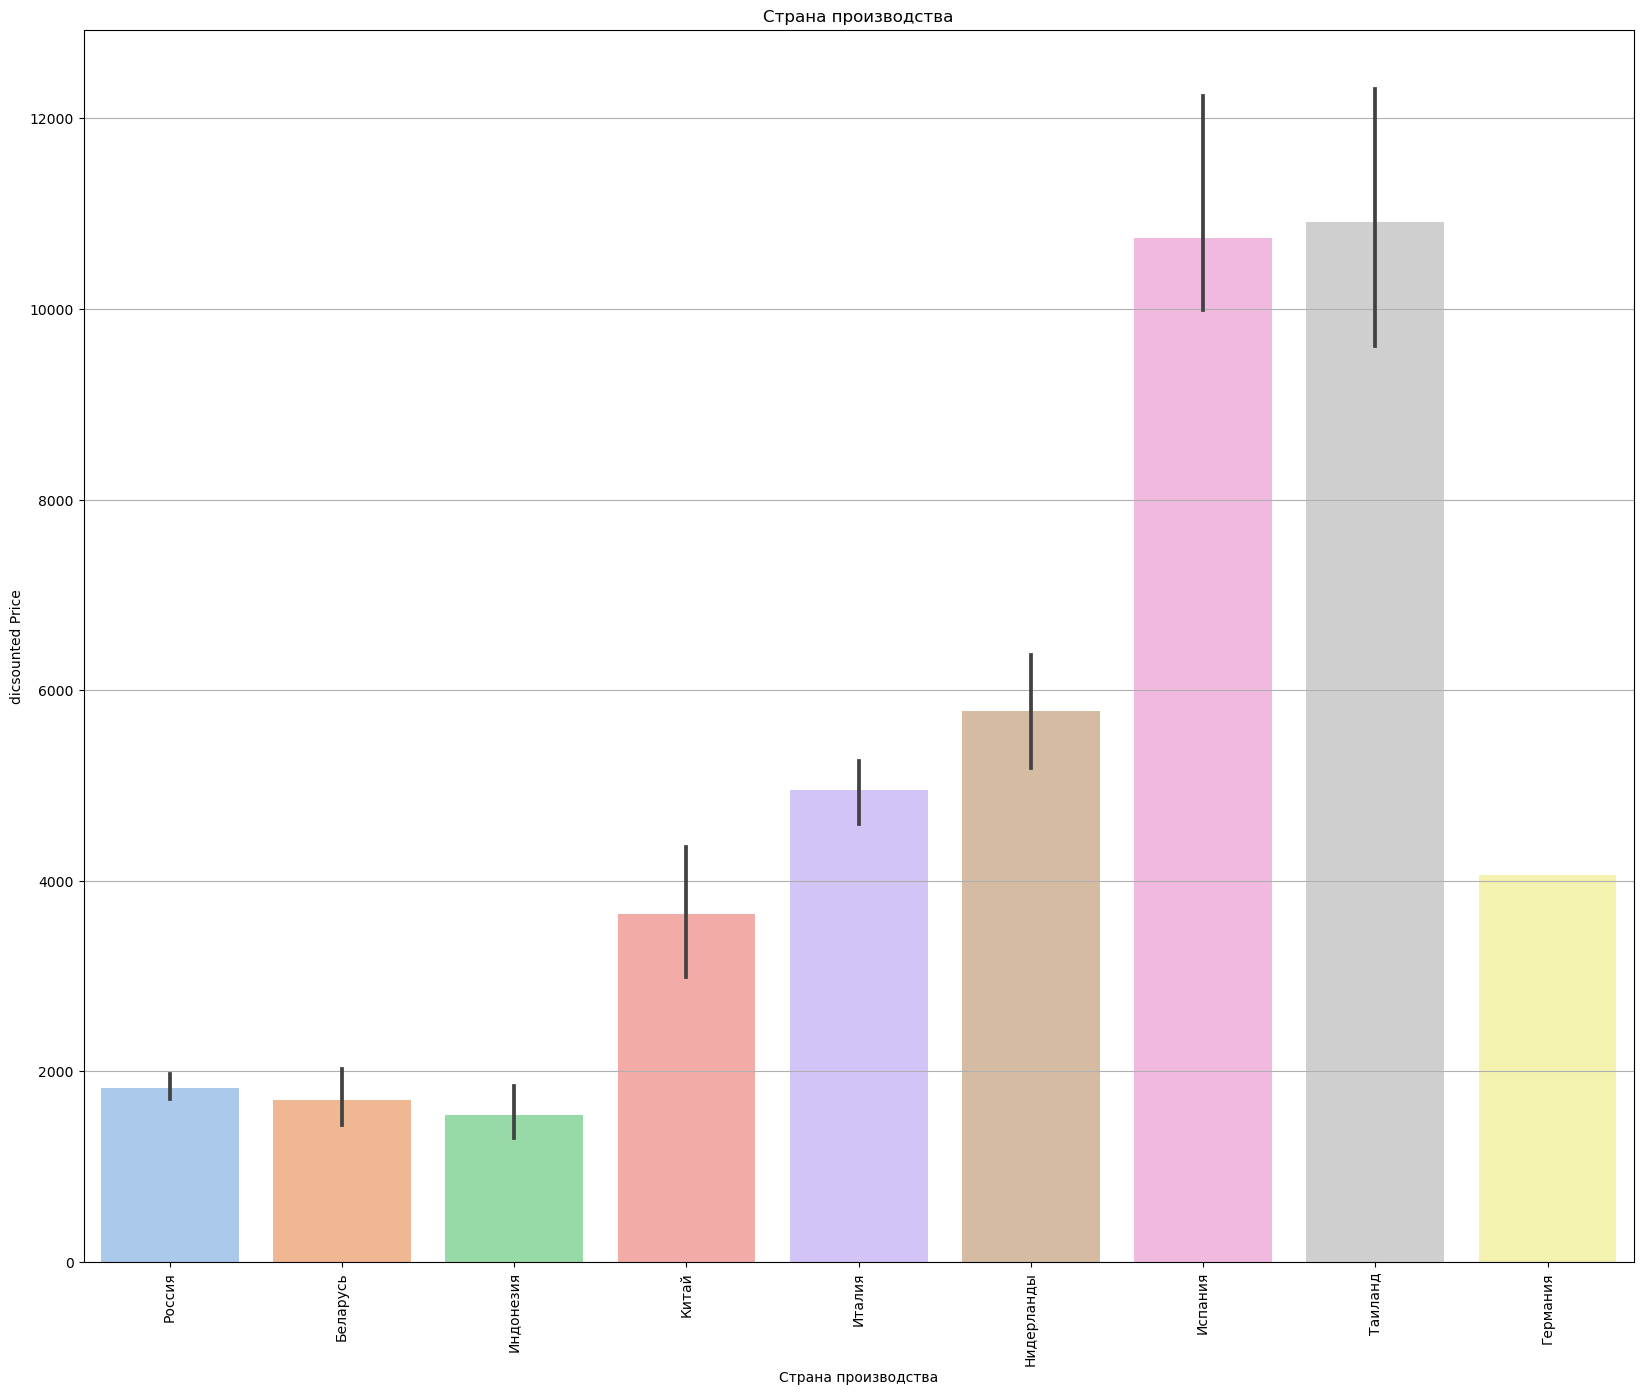

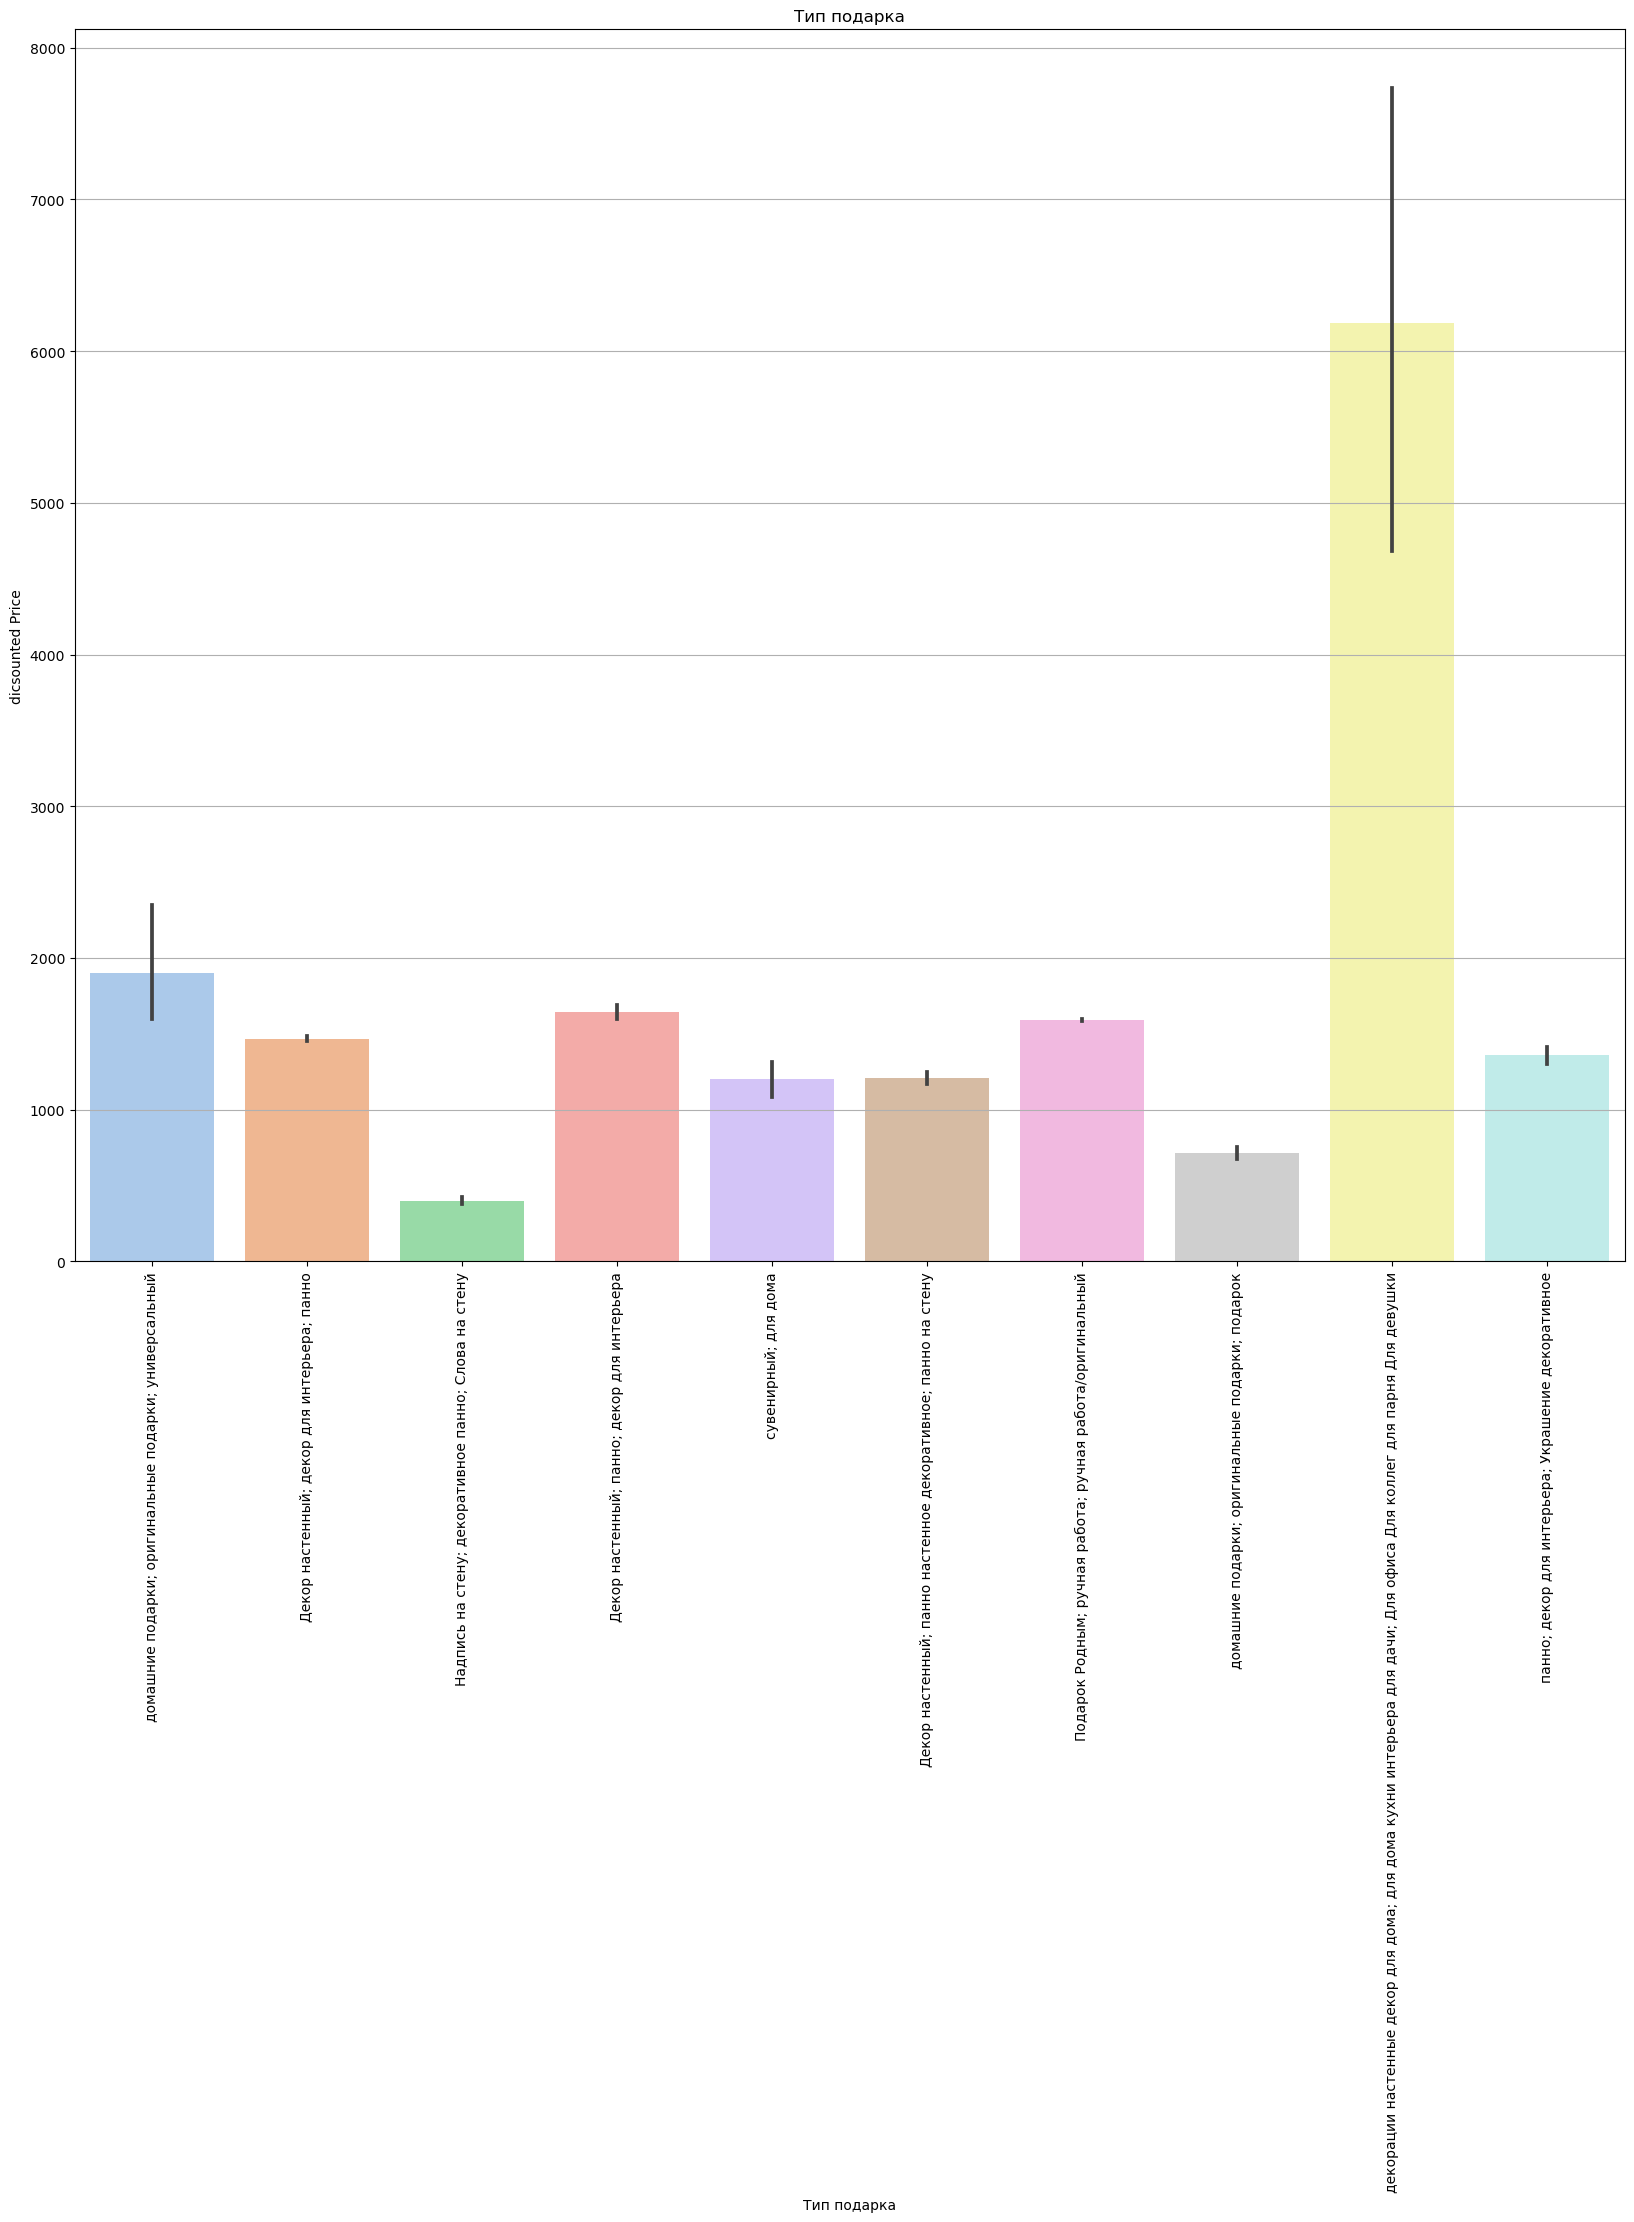

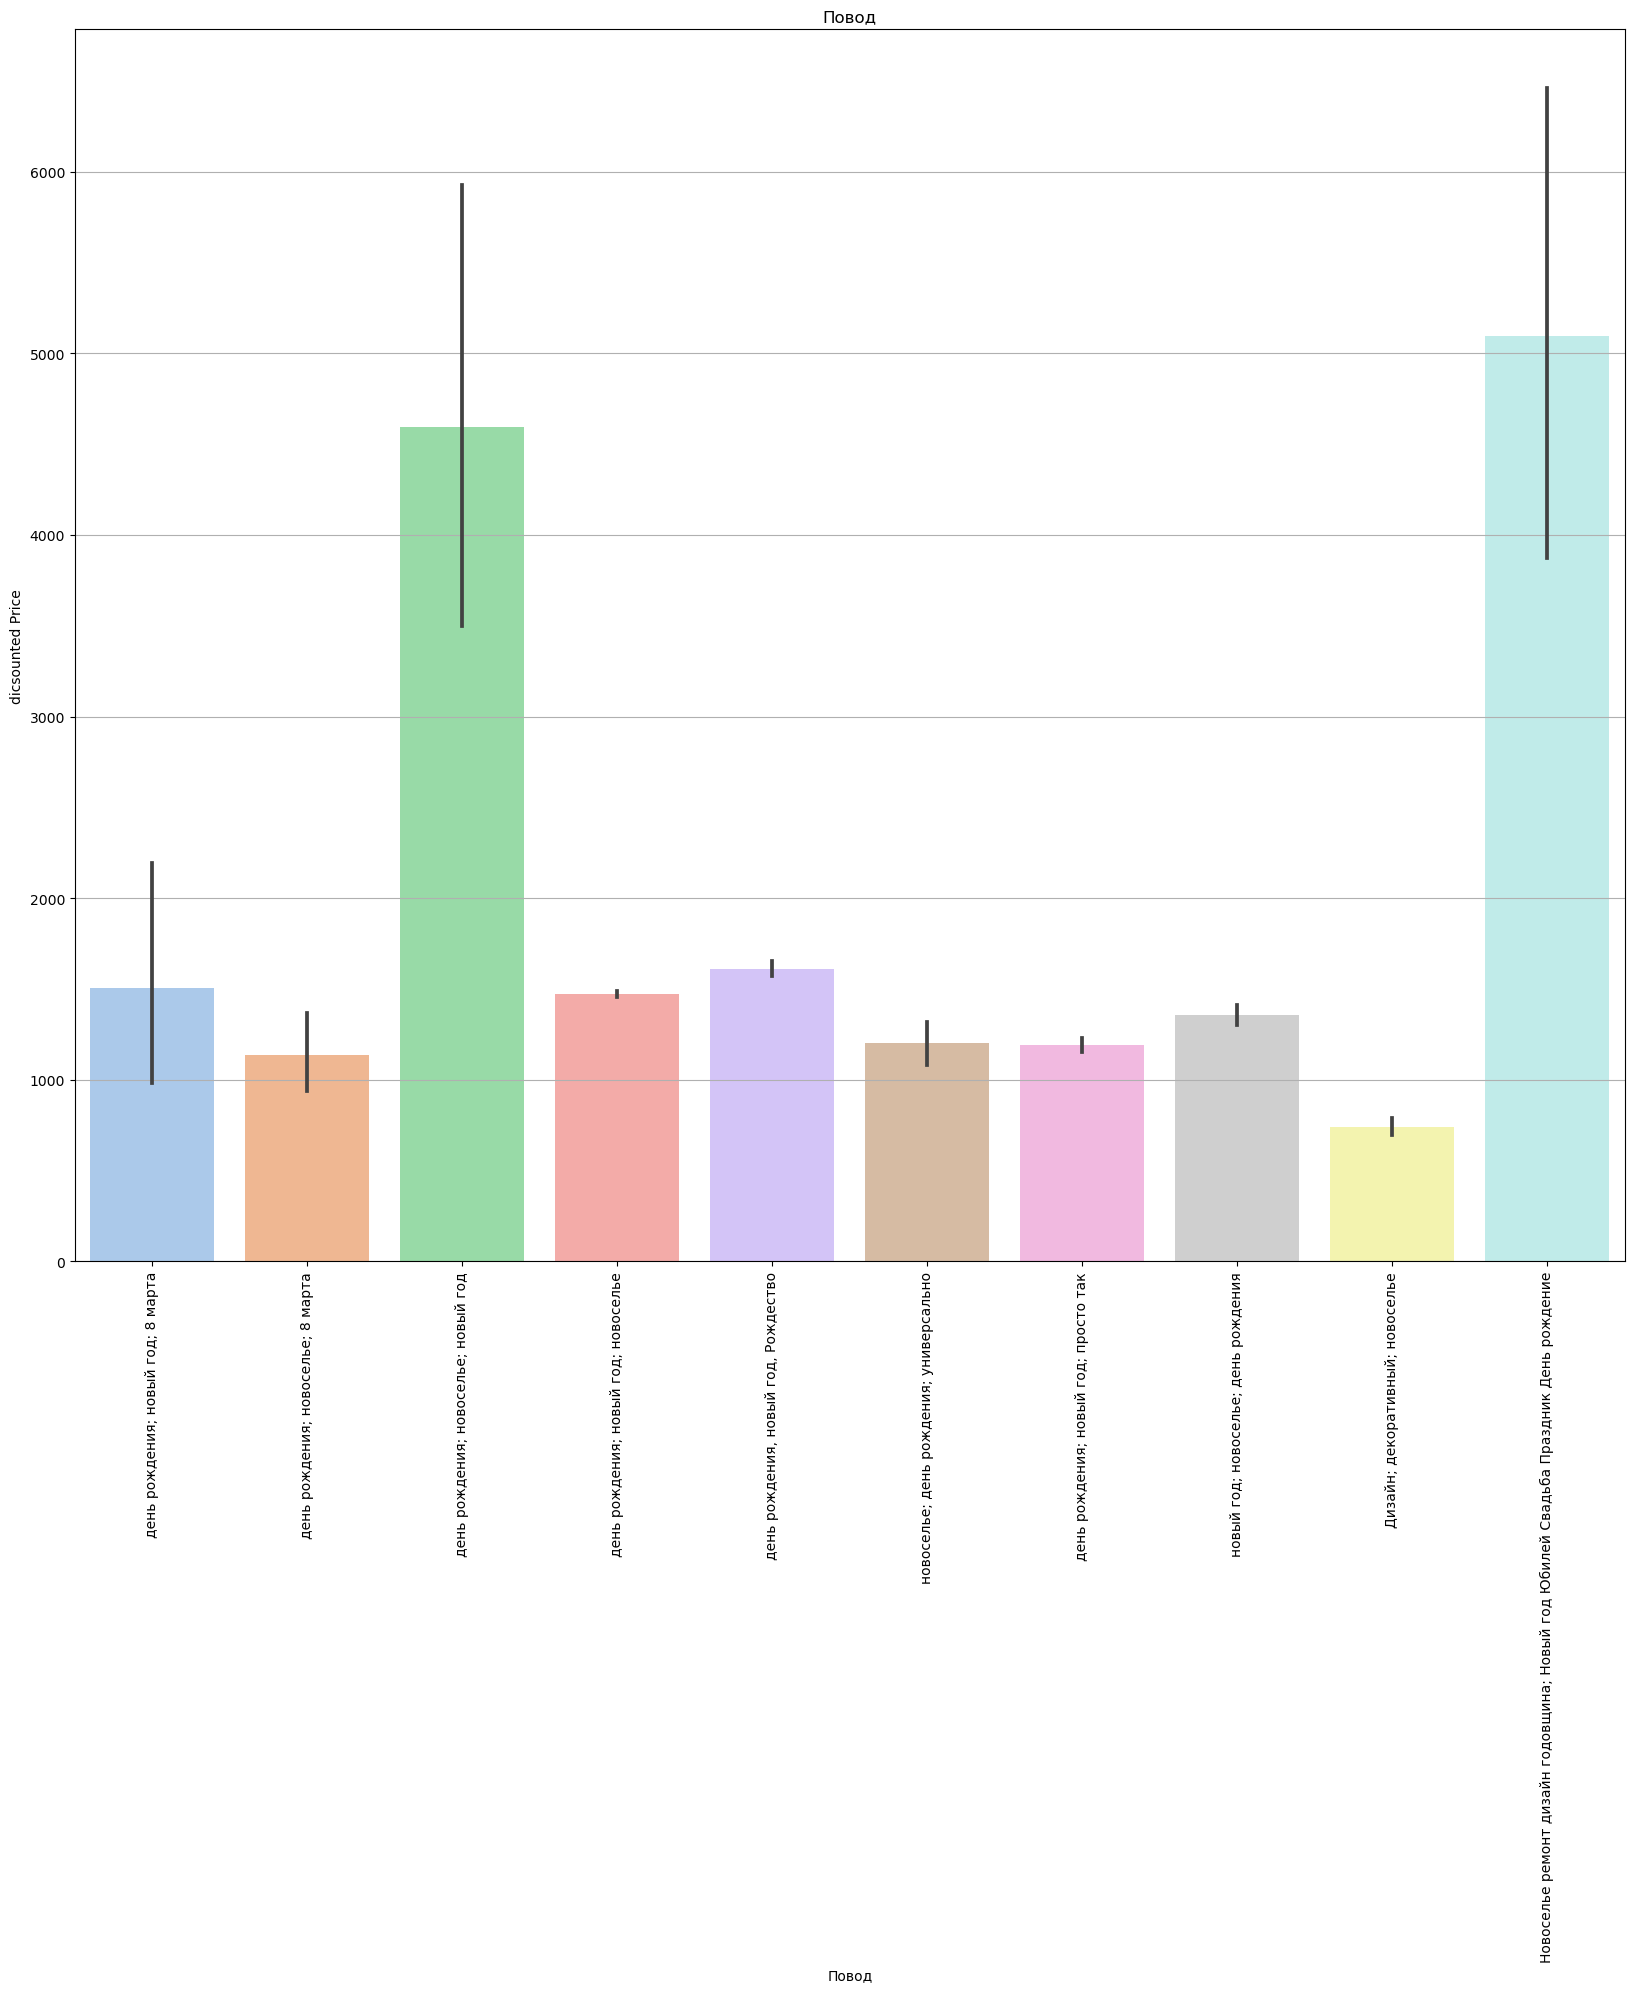

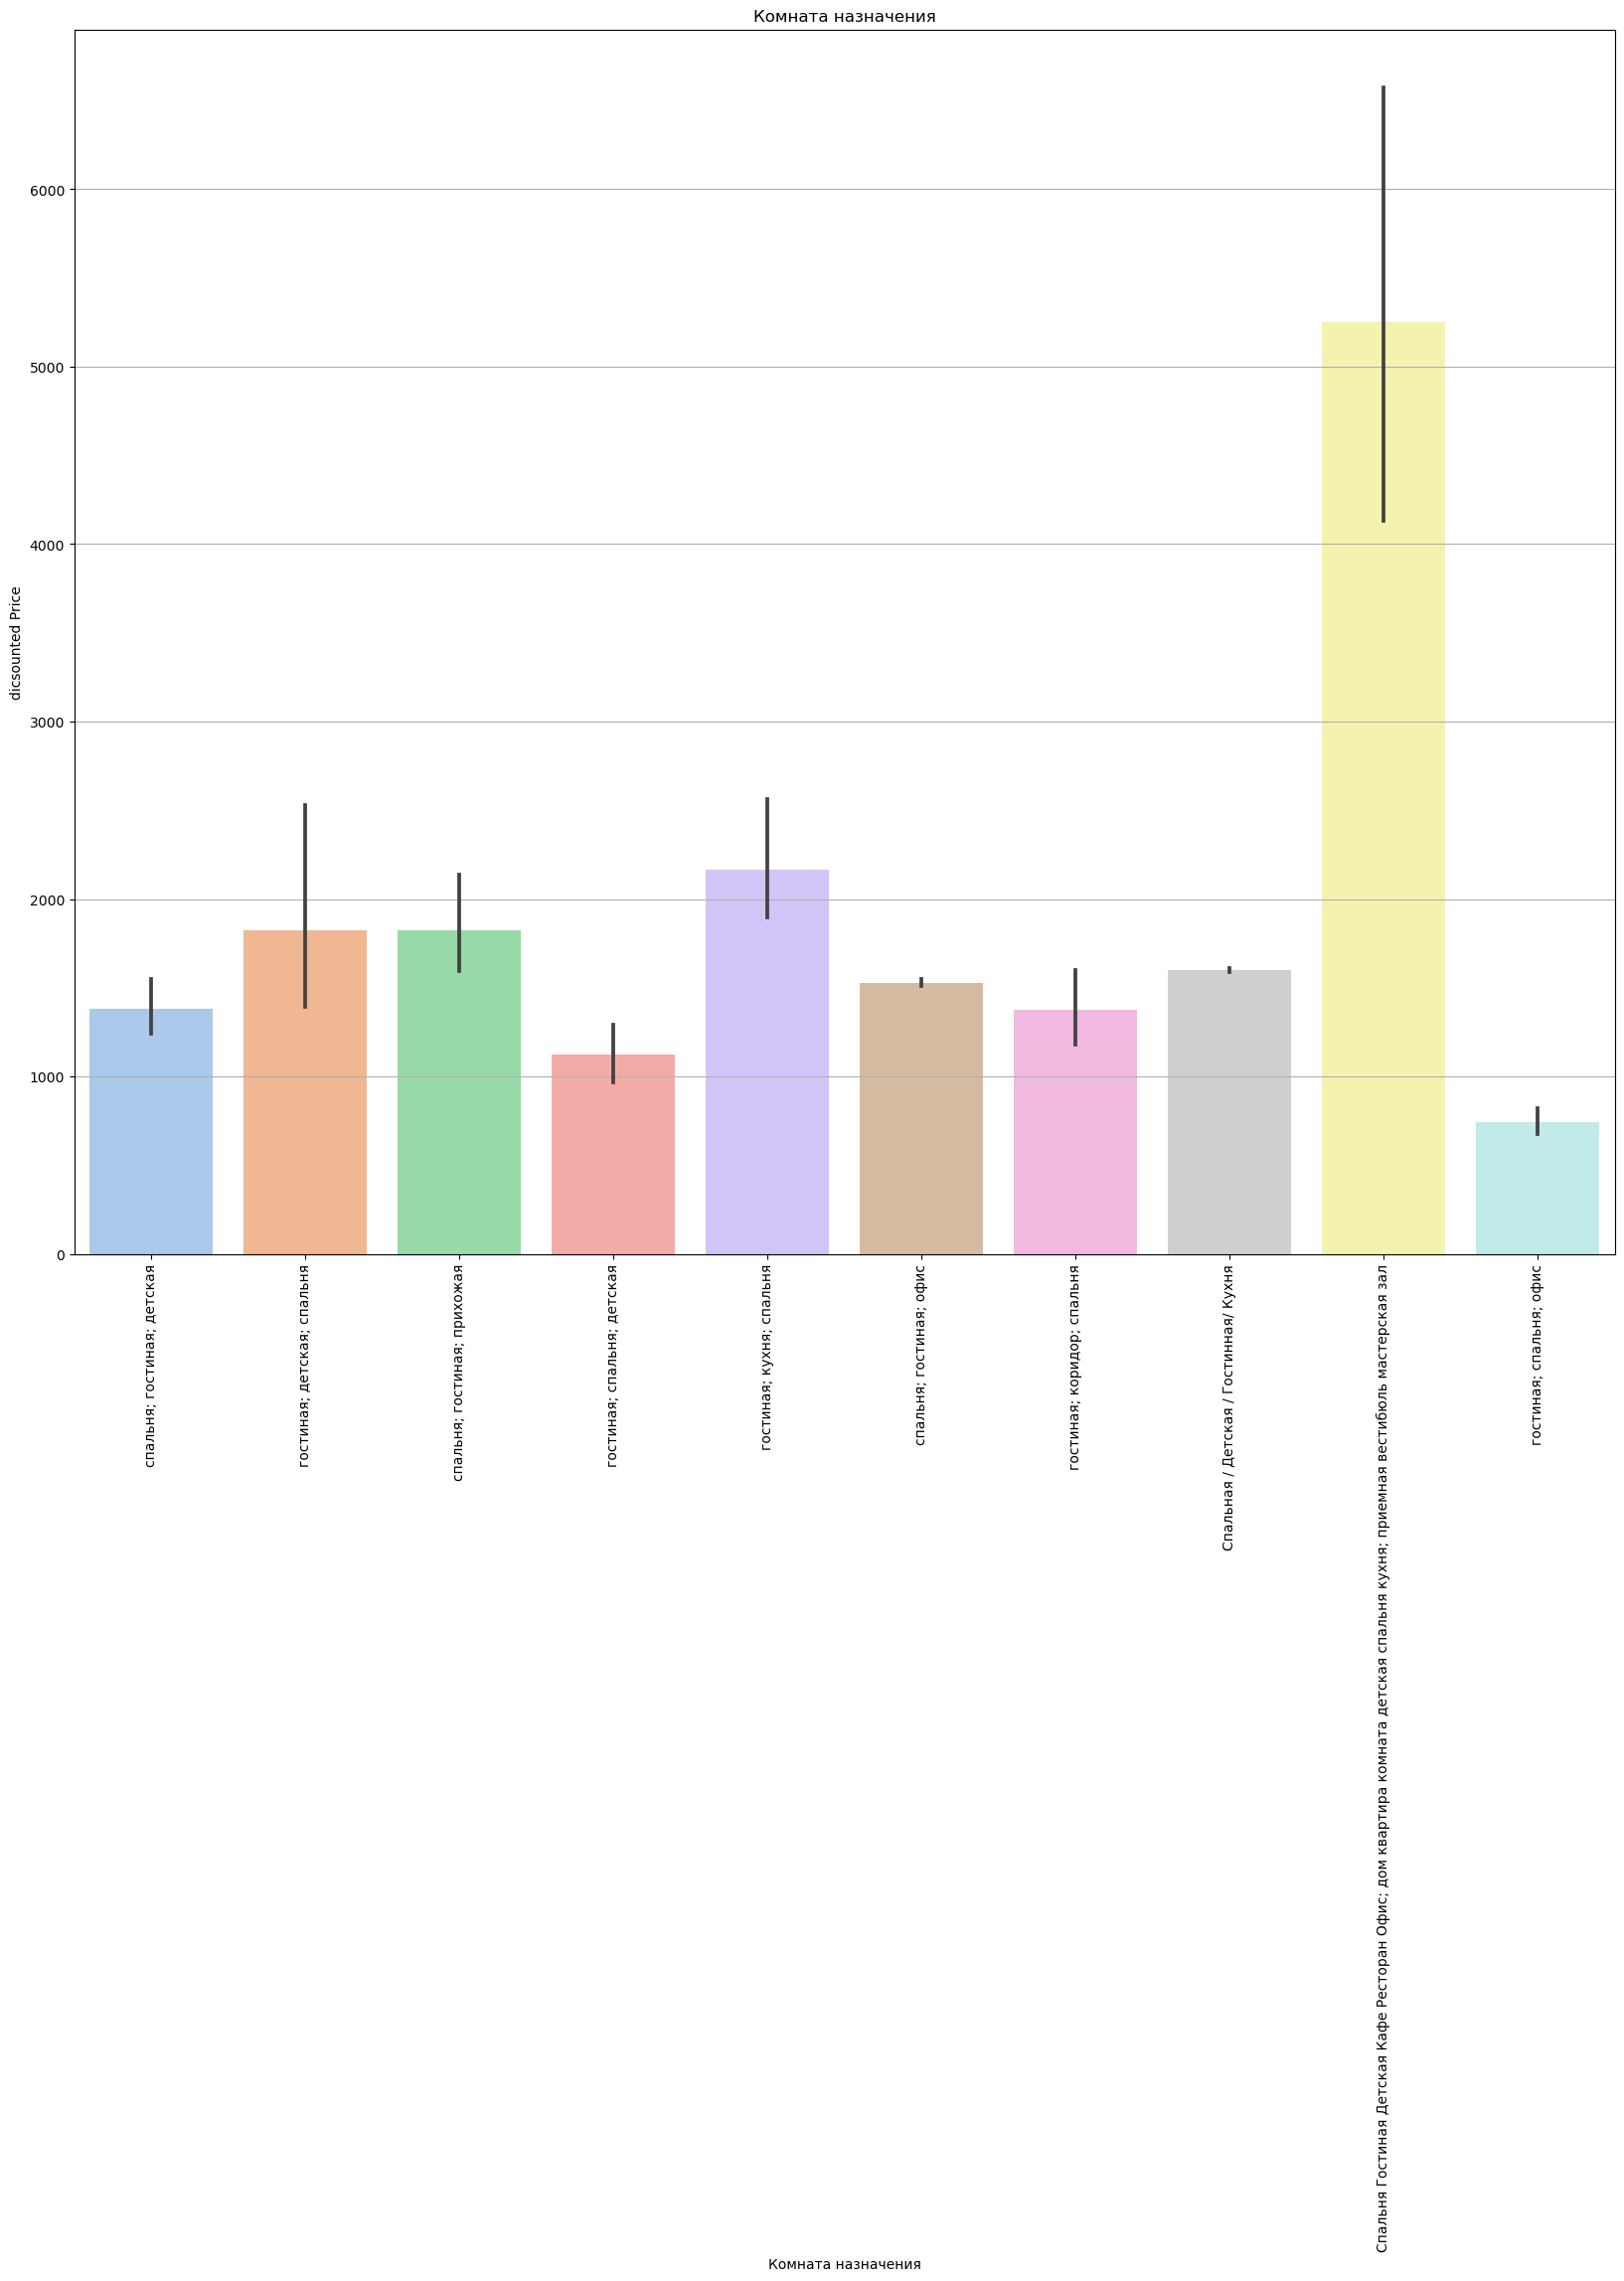

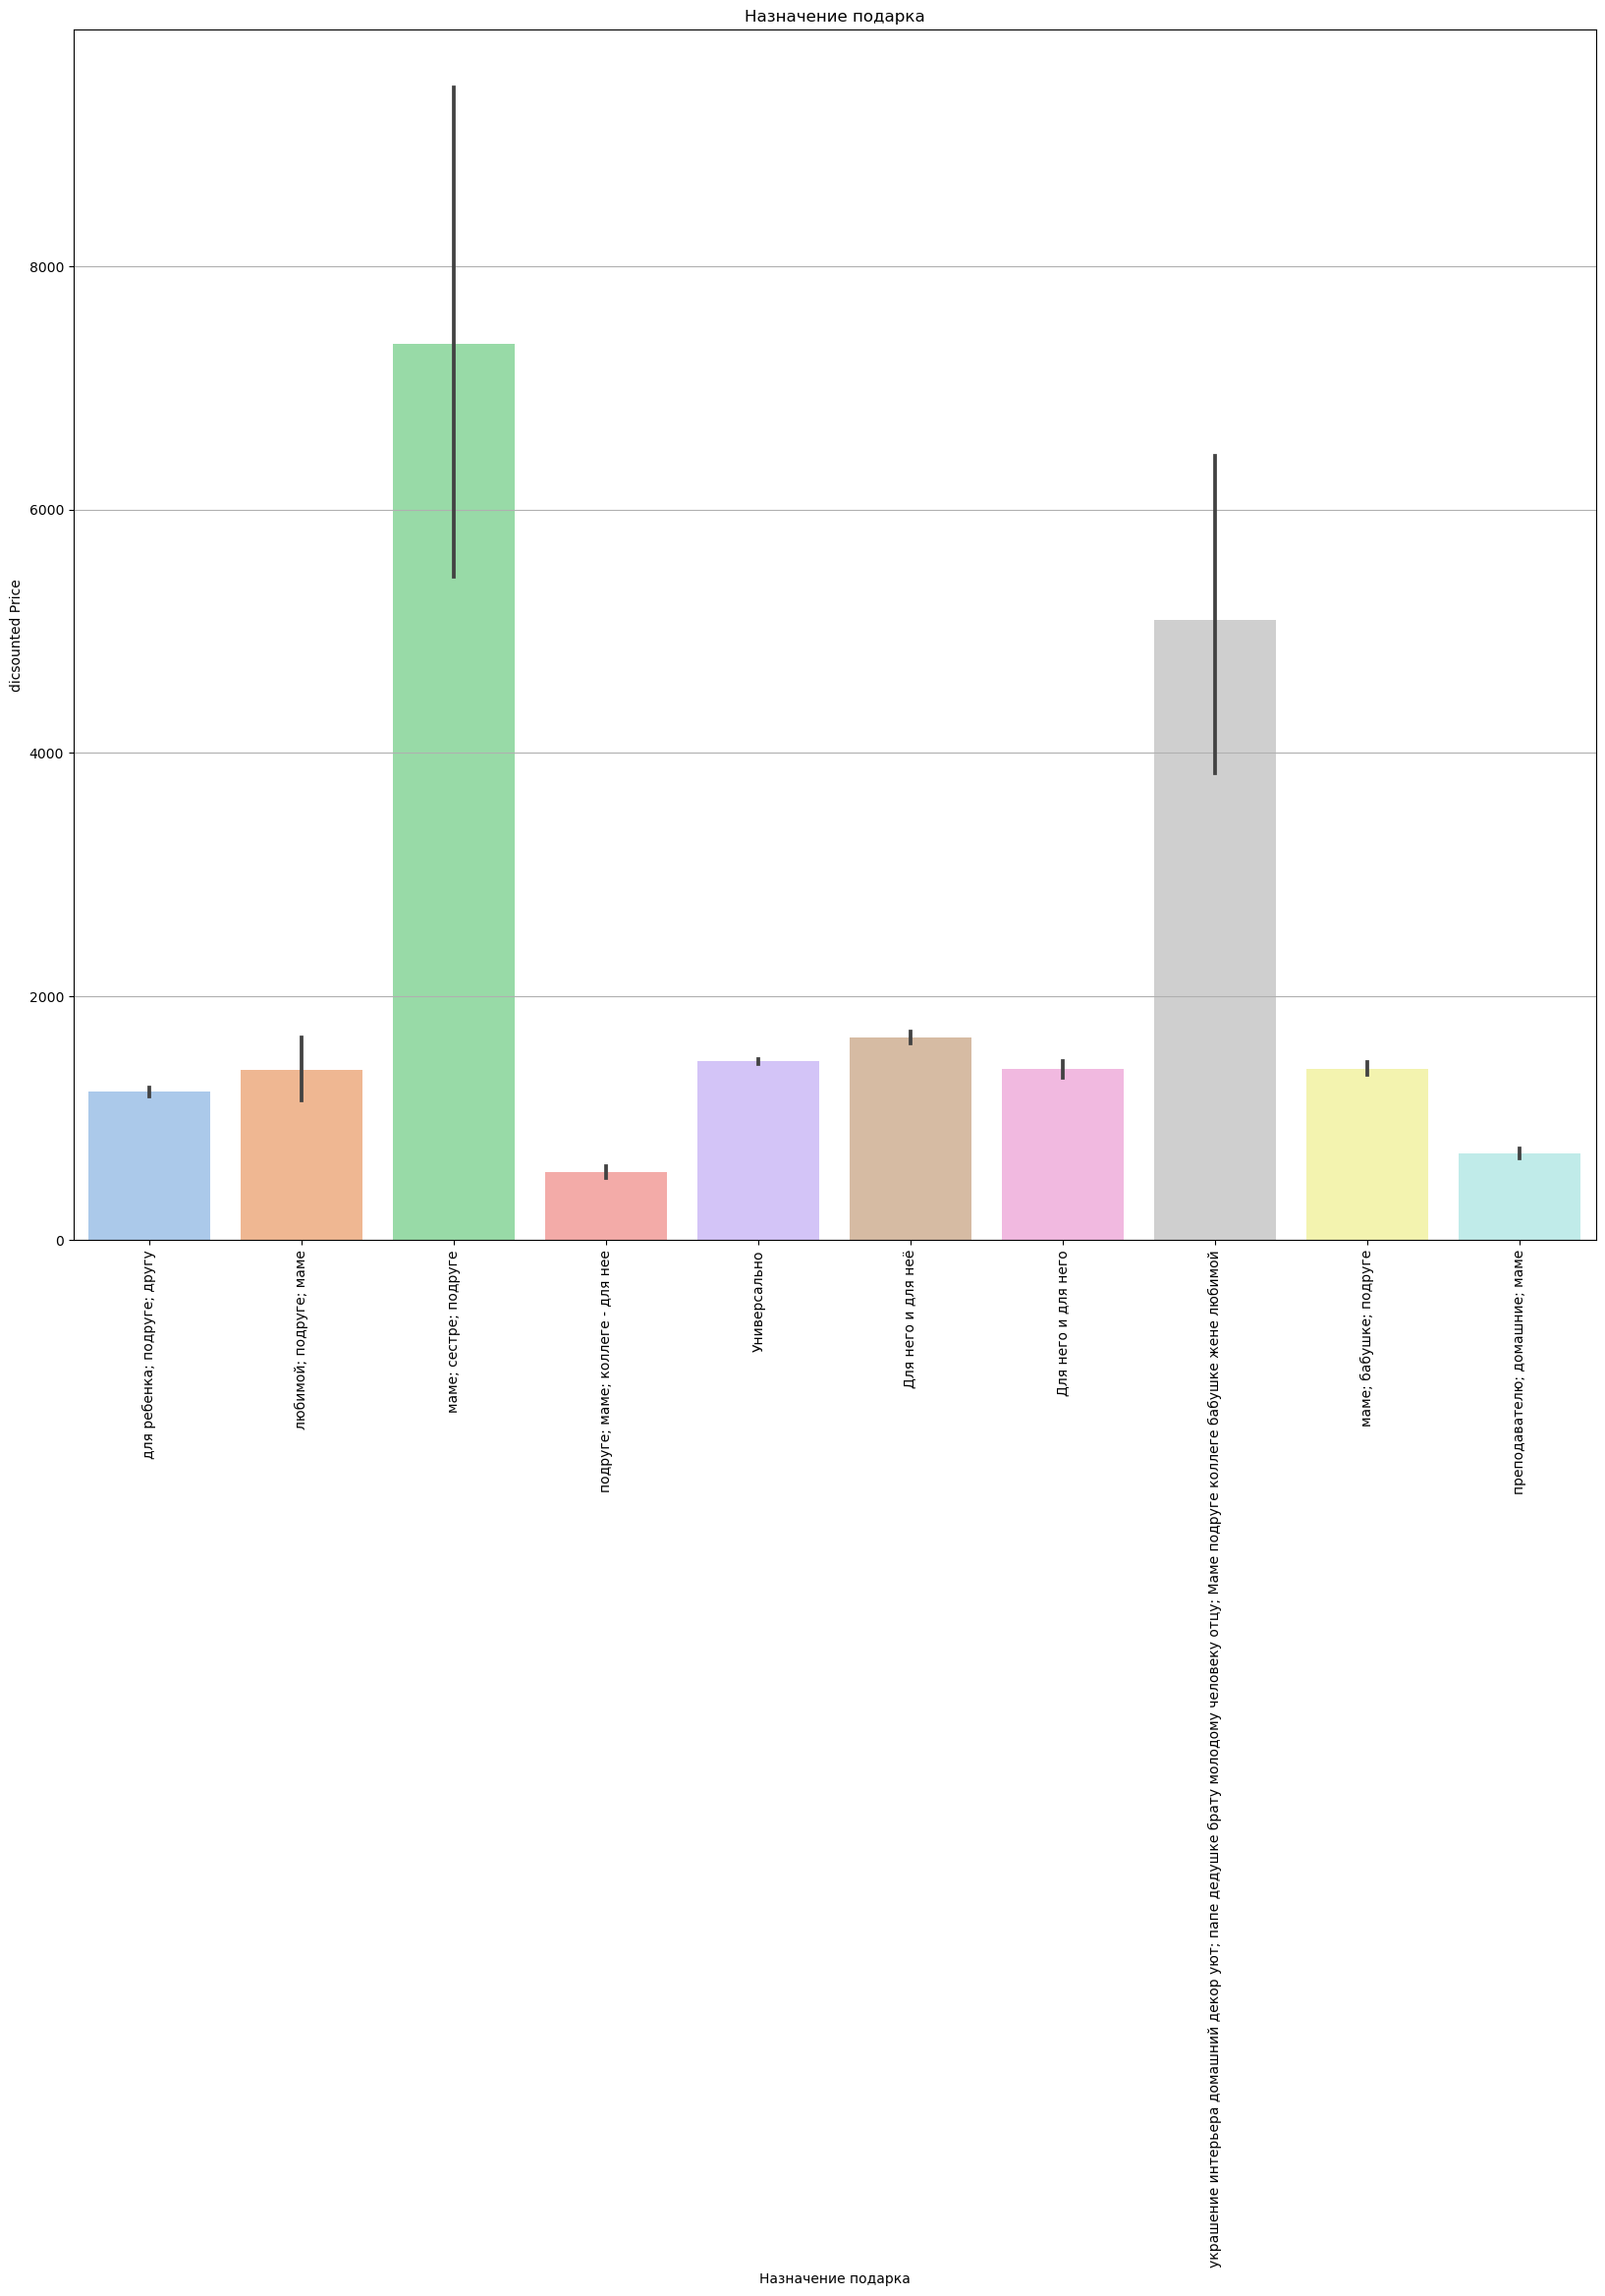

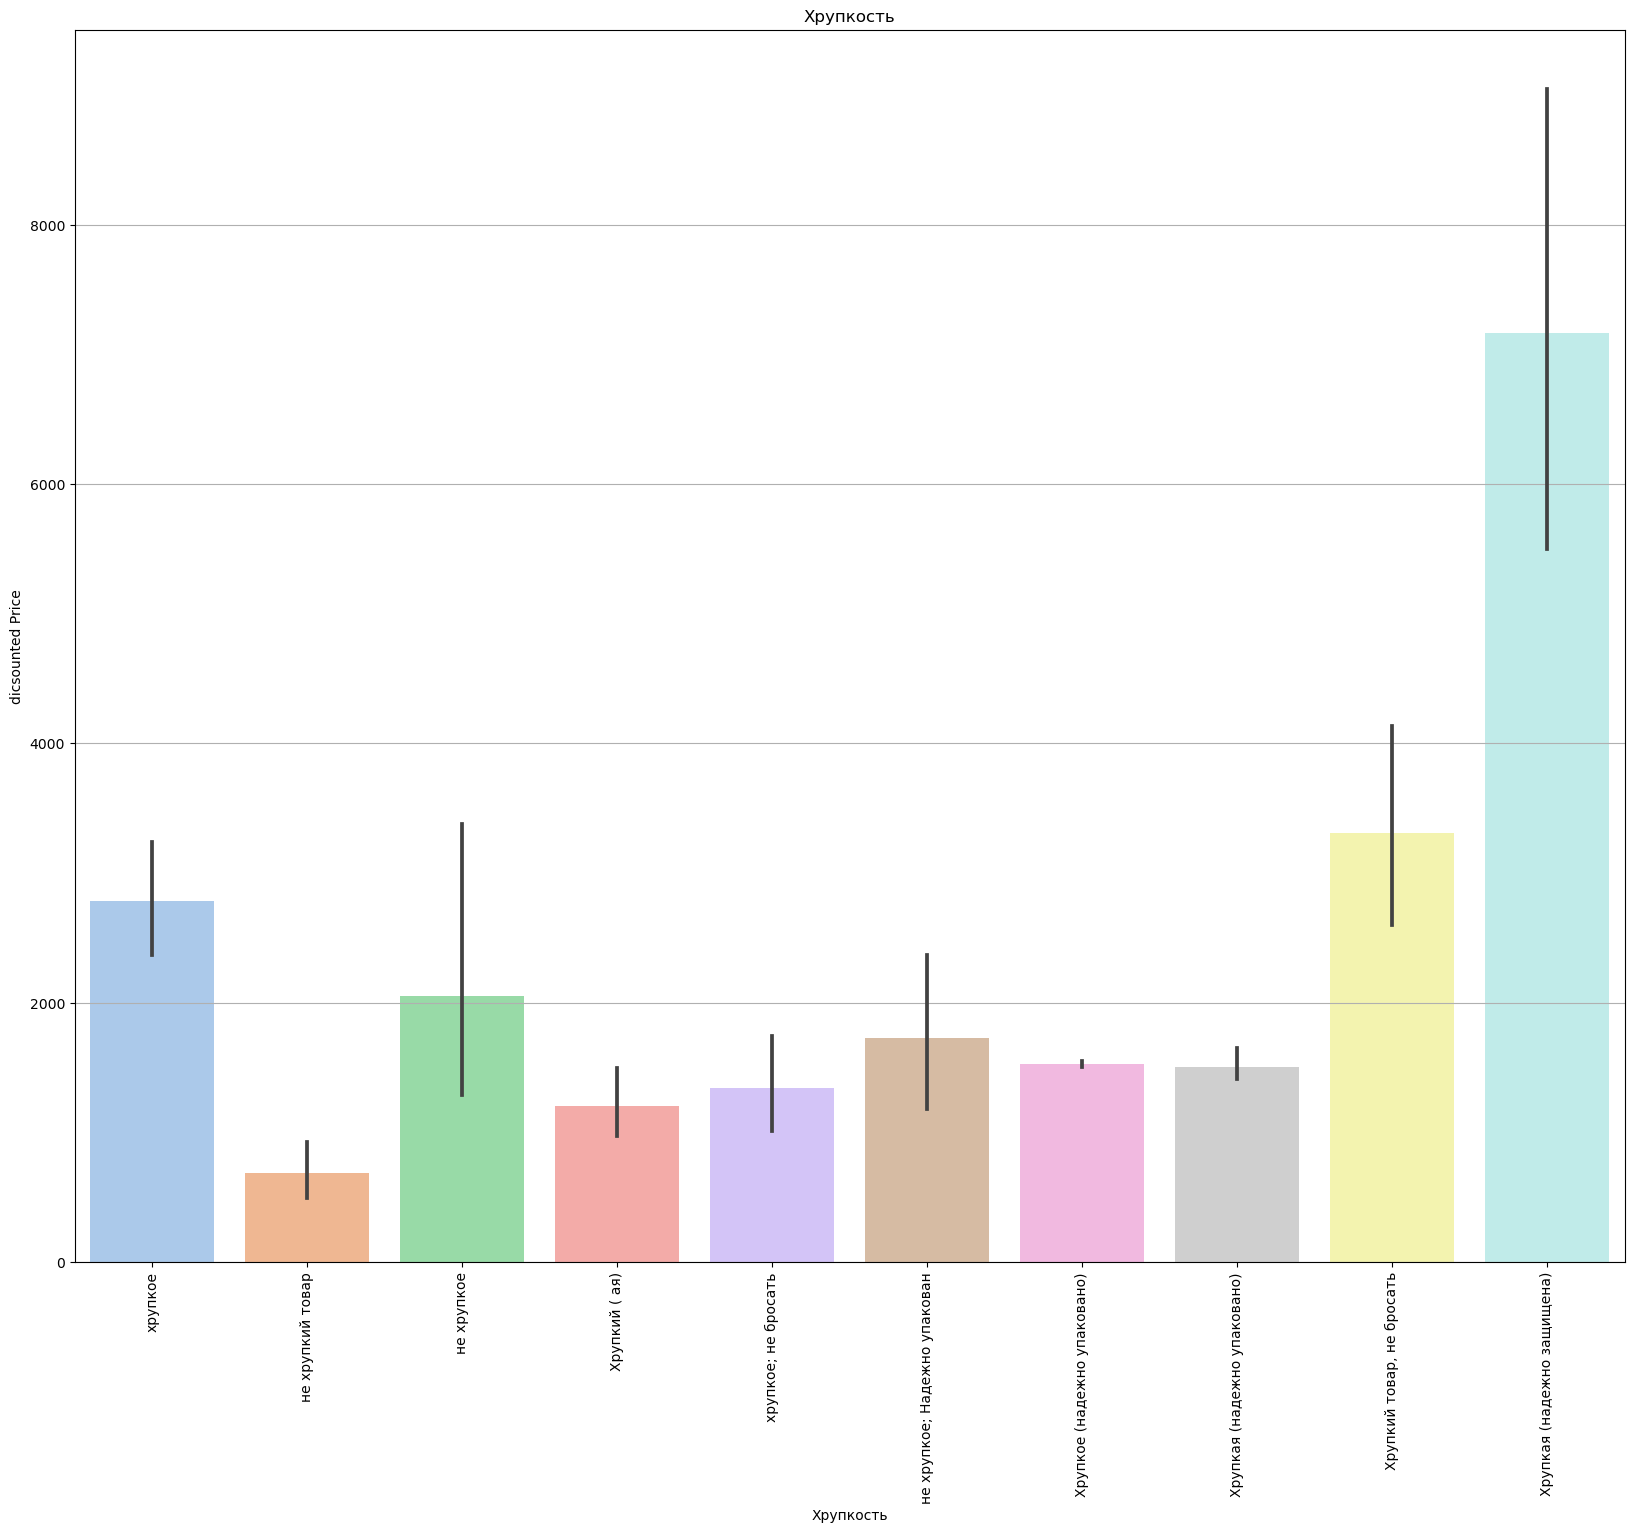

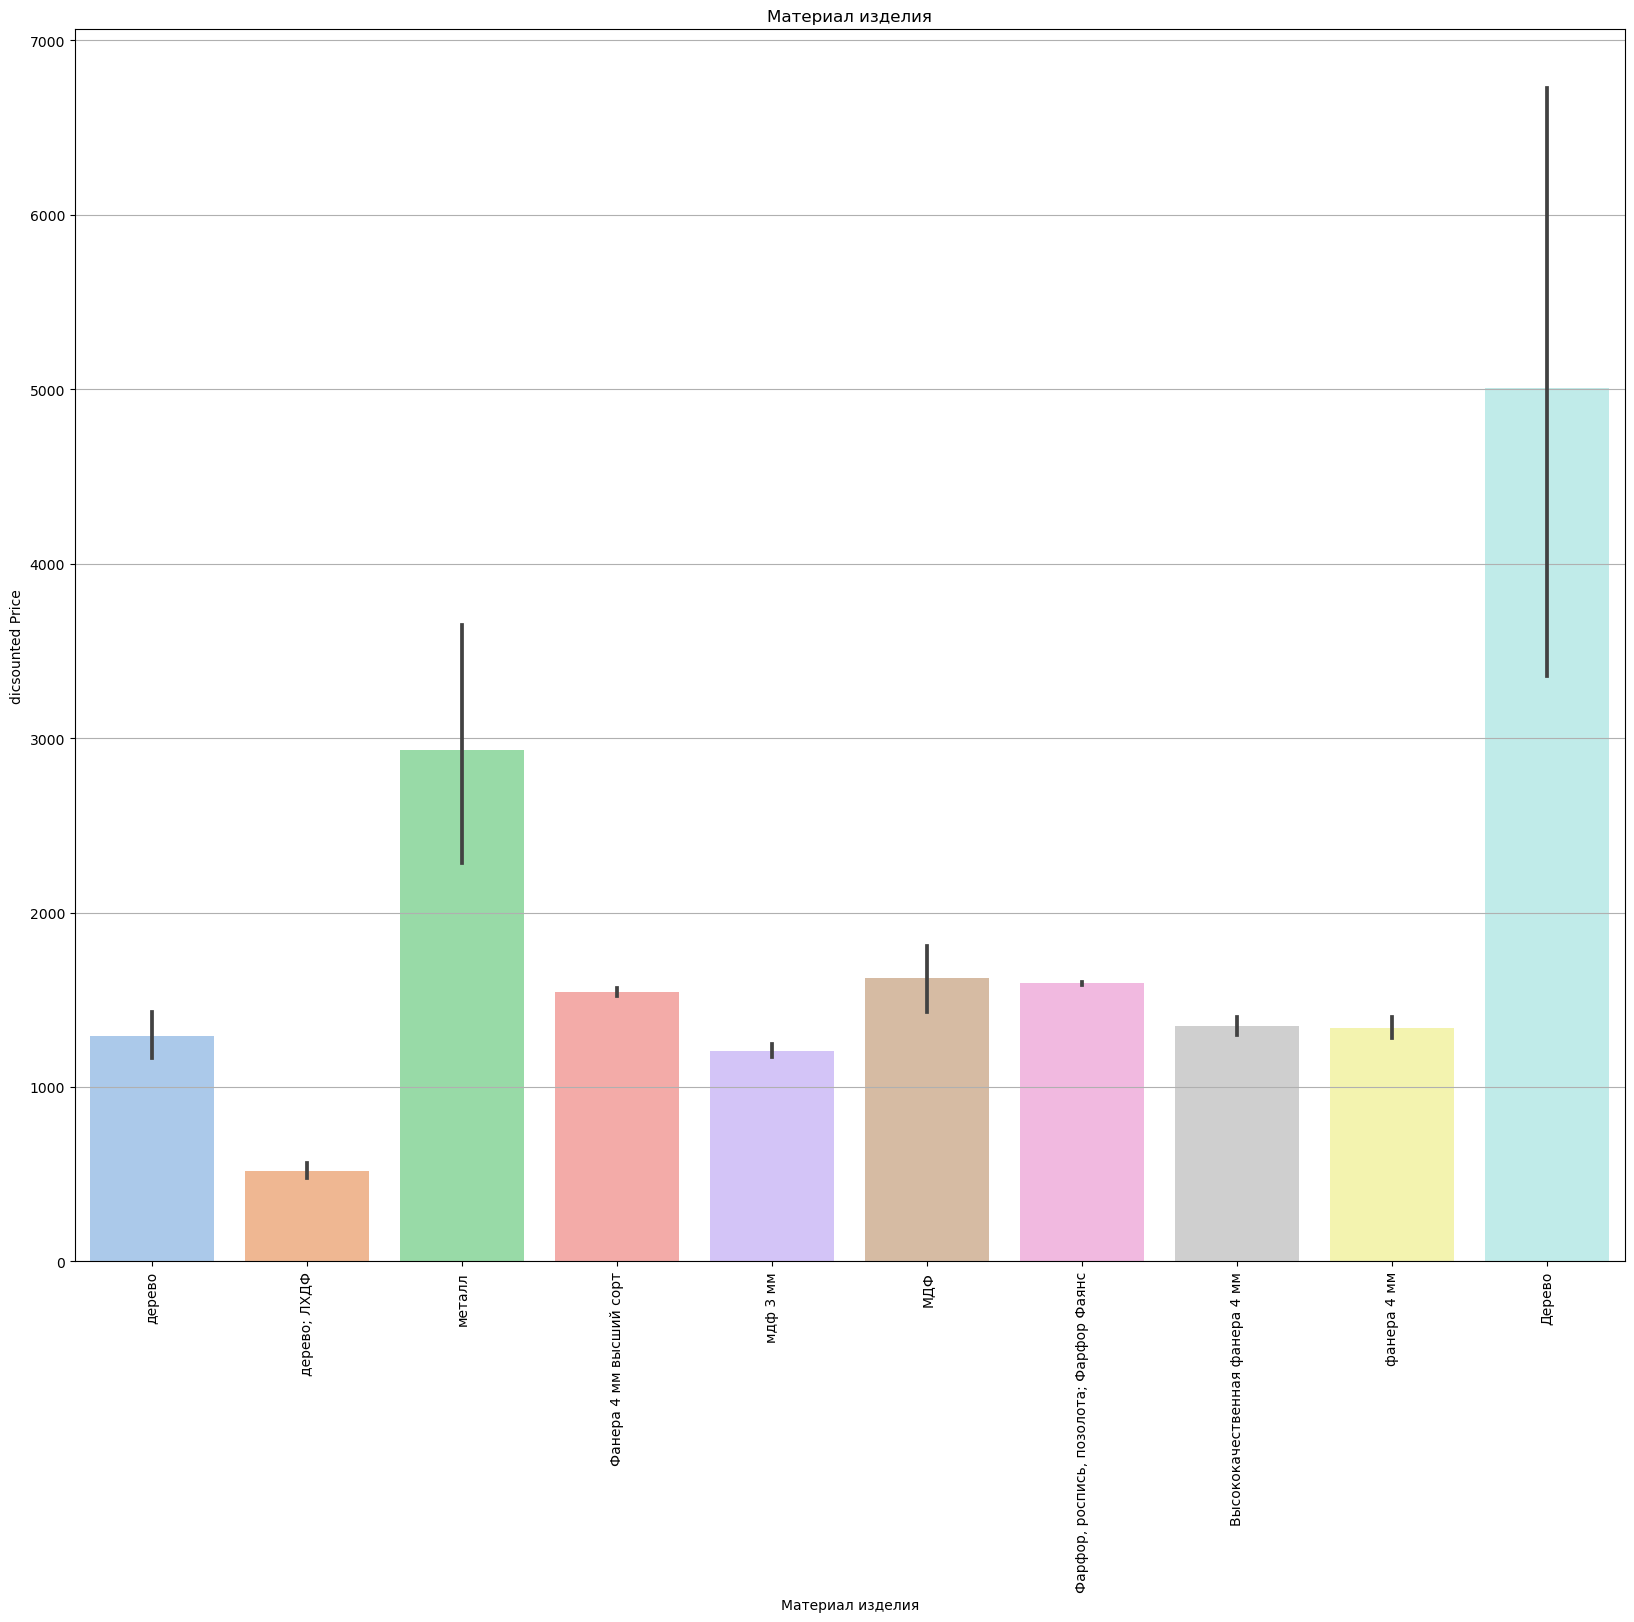

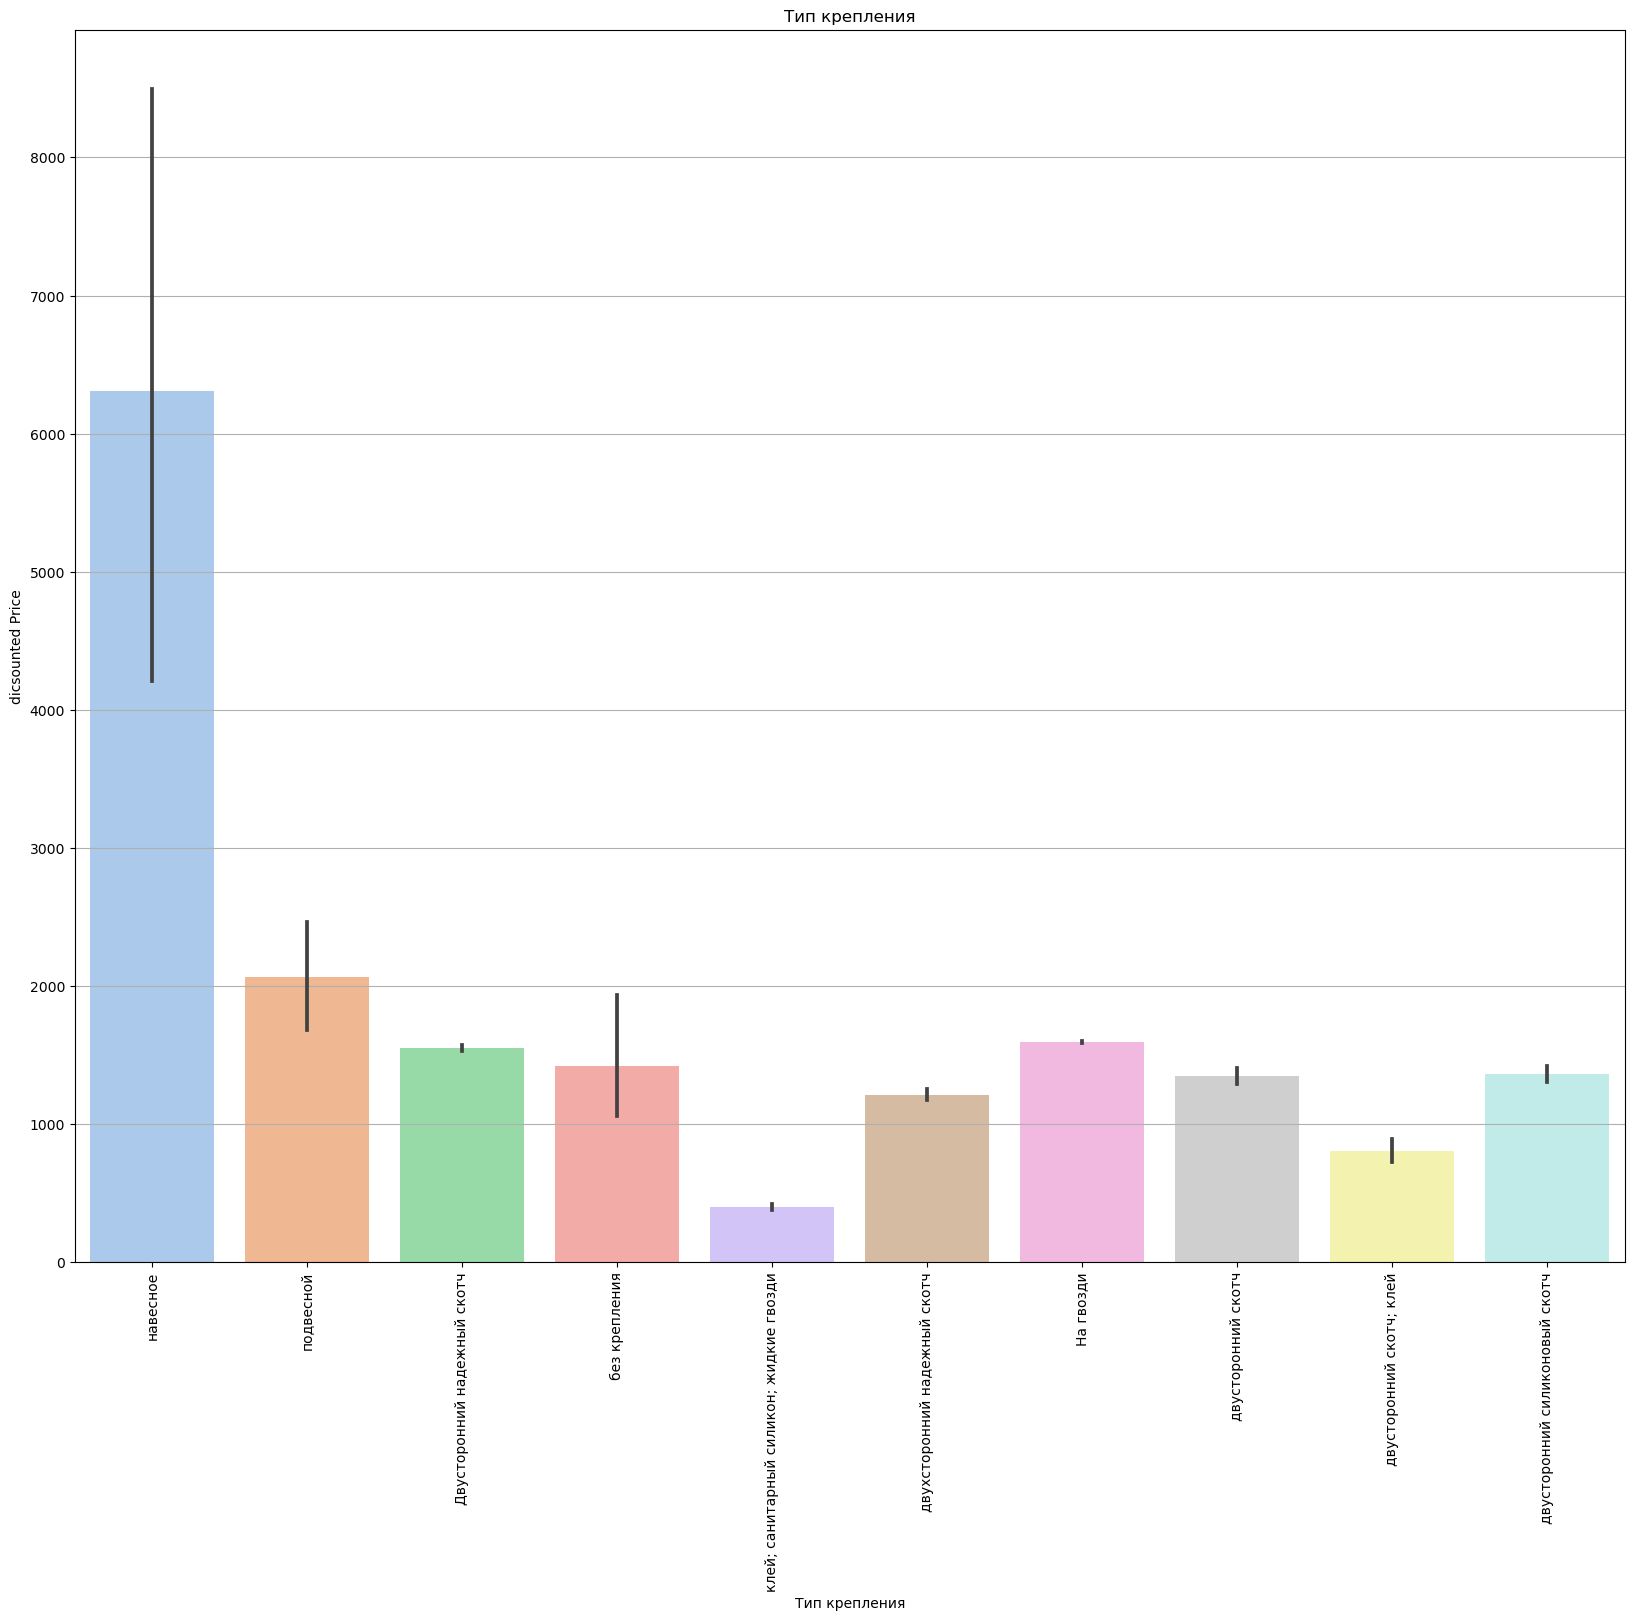

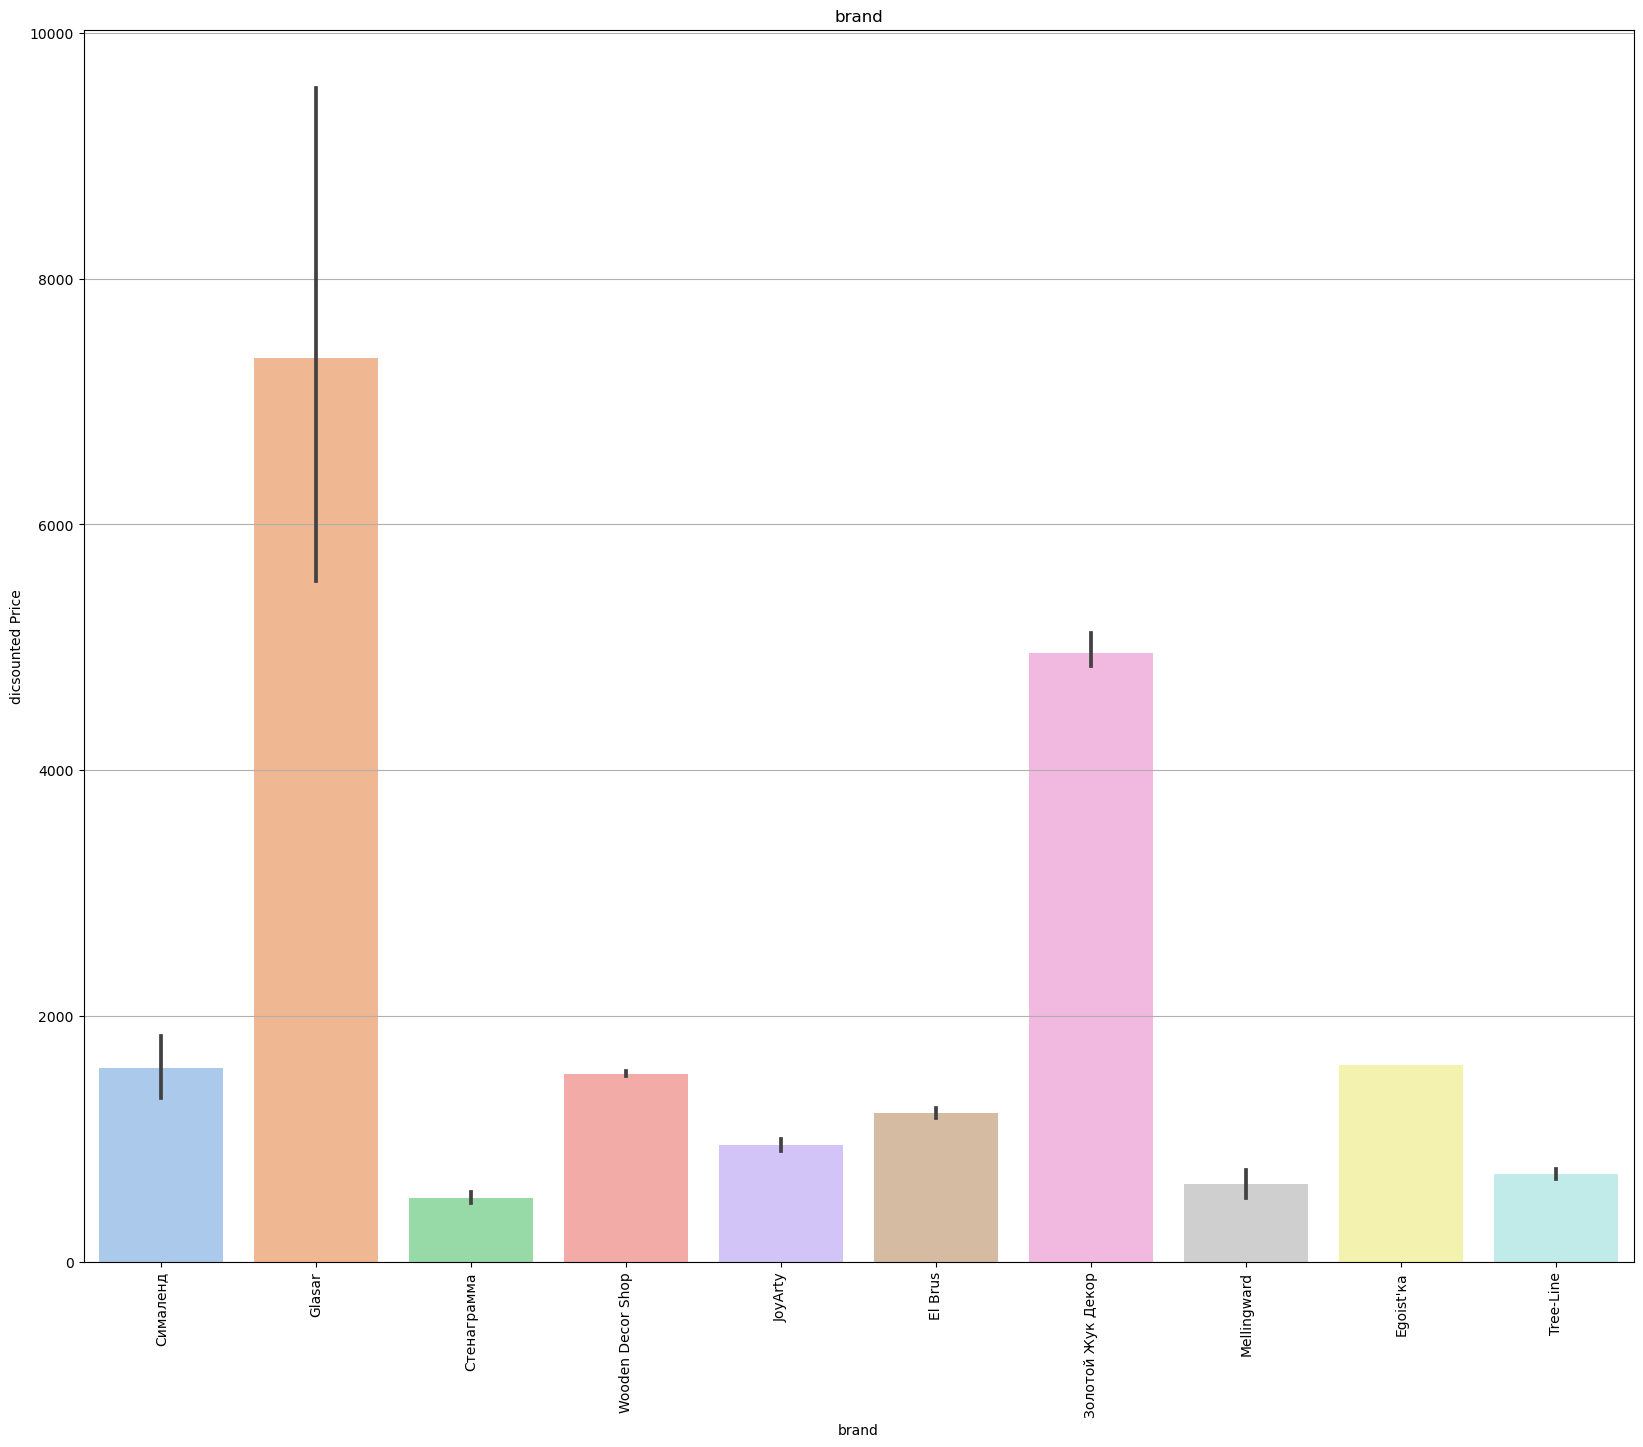

In [14]:
cat_graph(df1,CATEGORICAL_COLUMNS1)

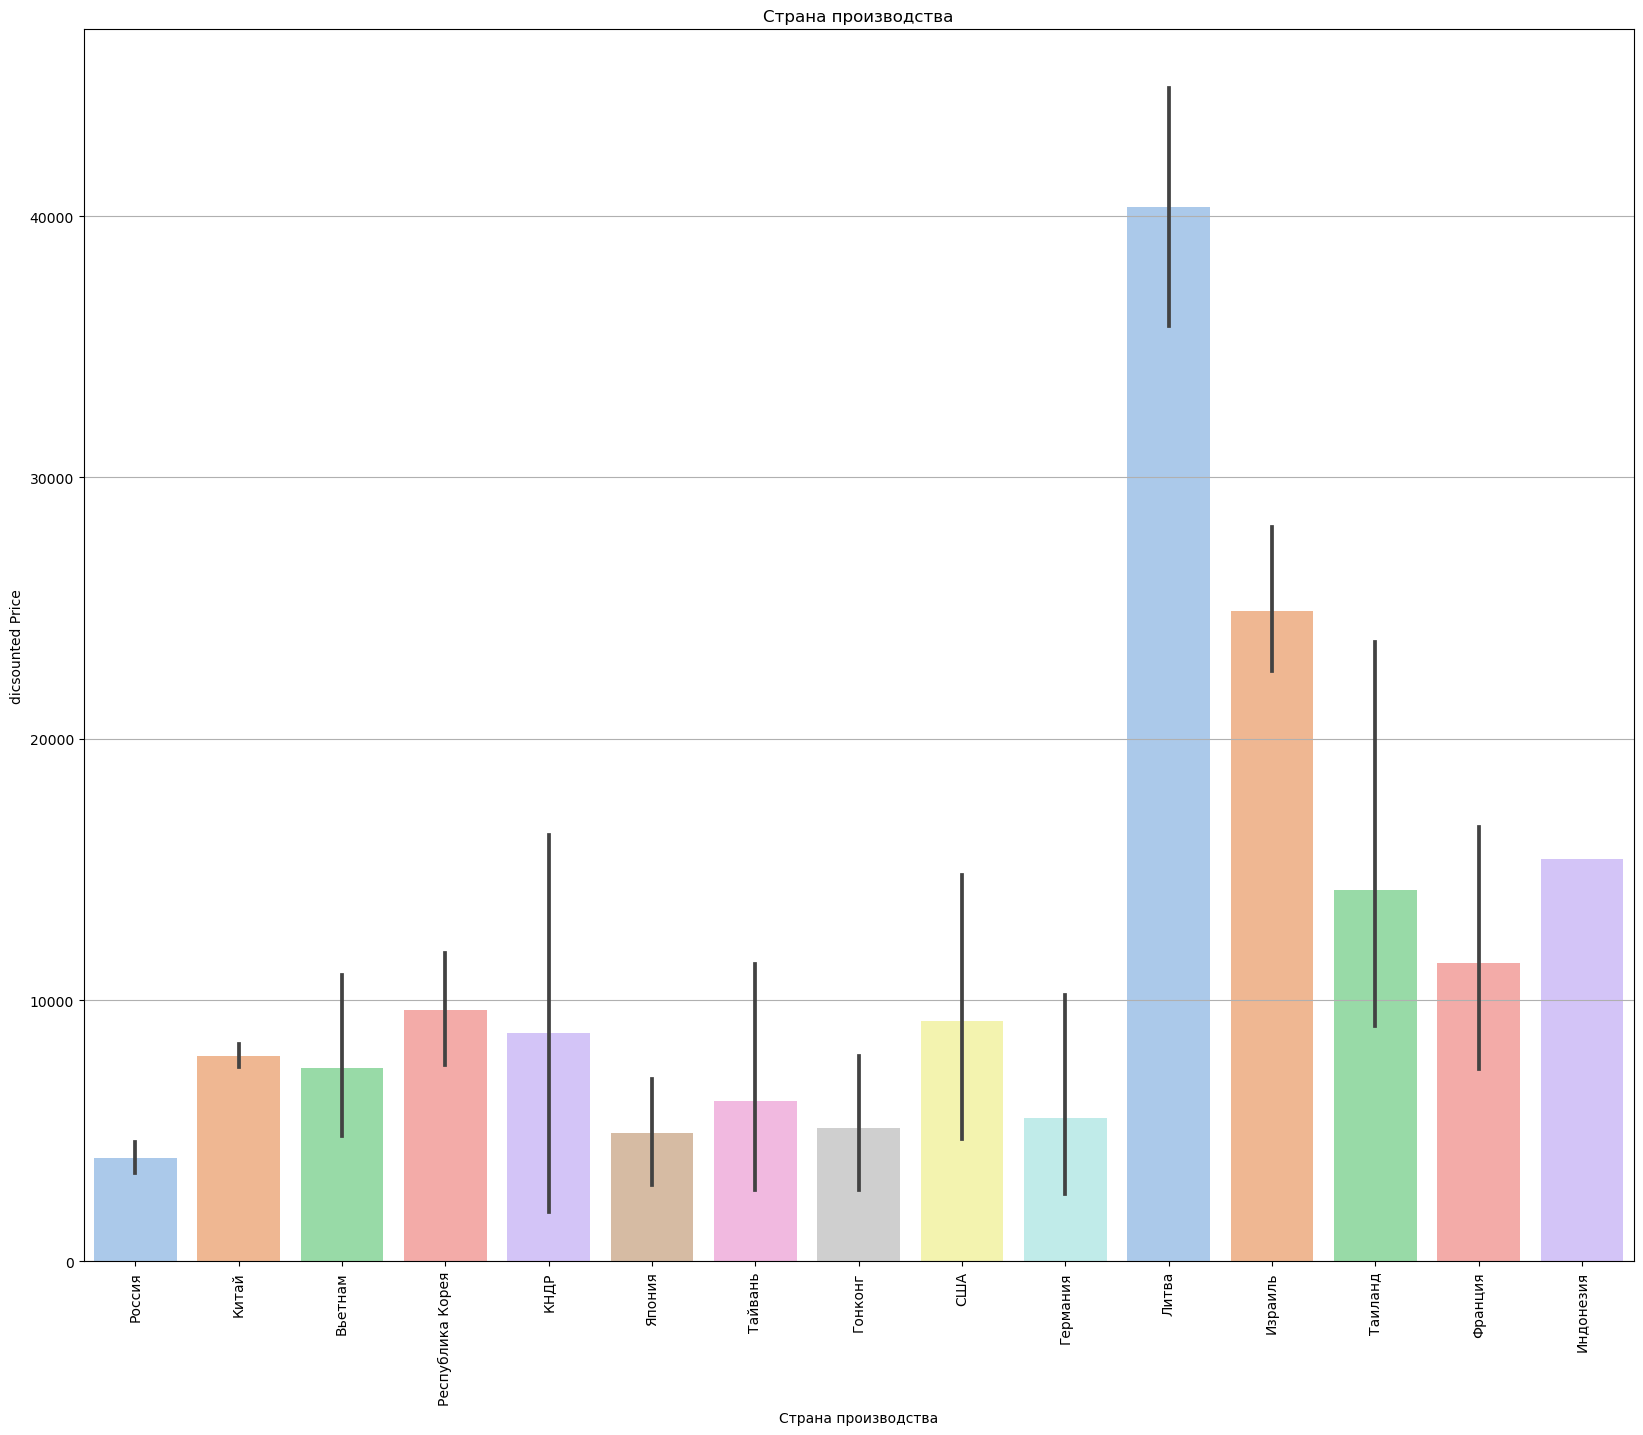

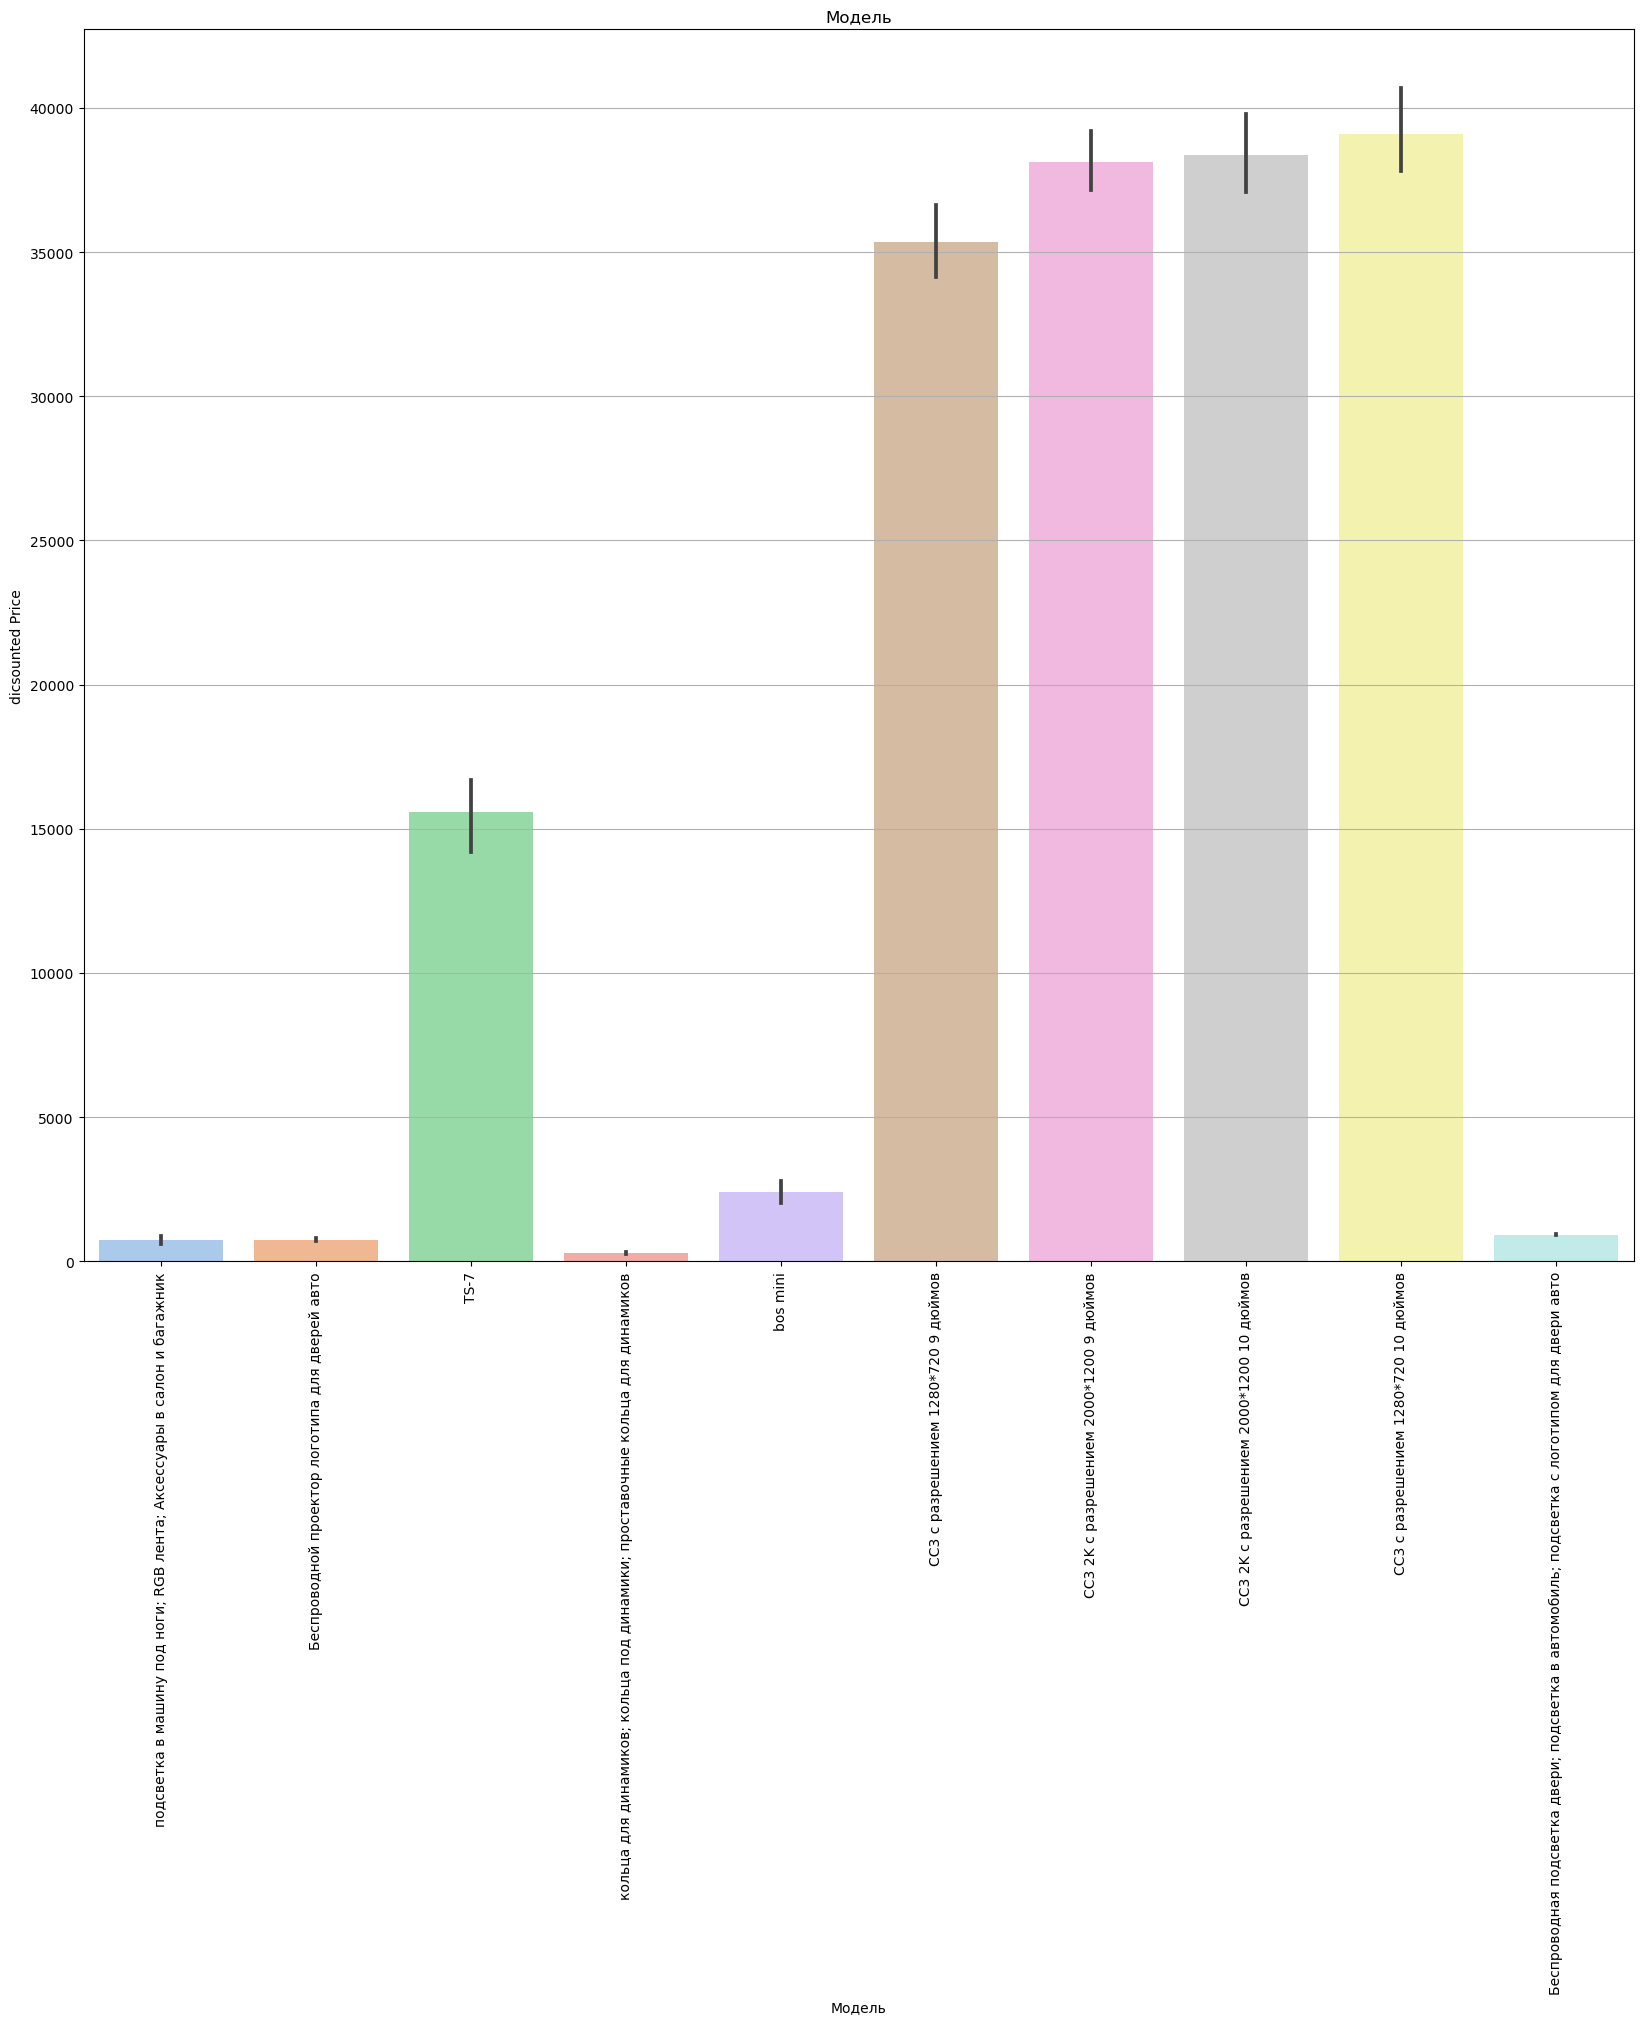

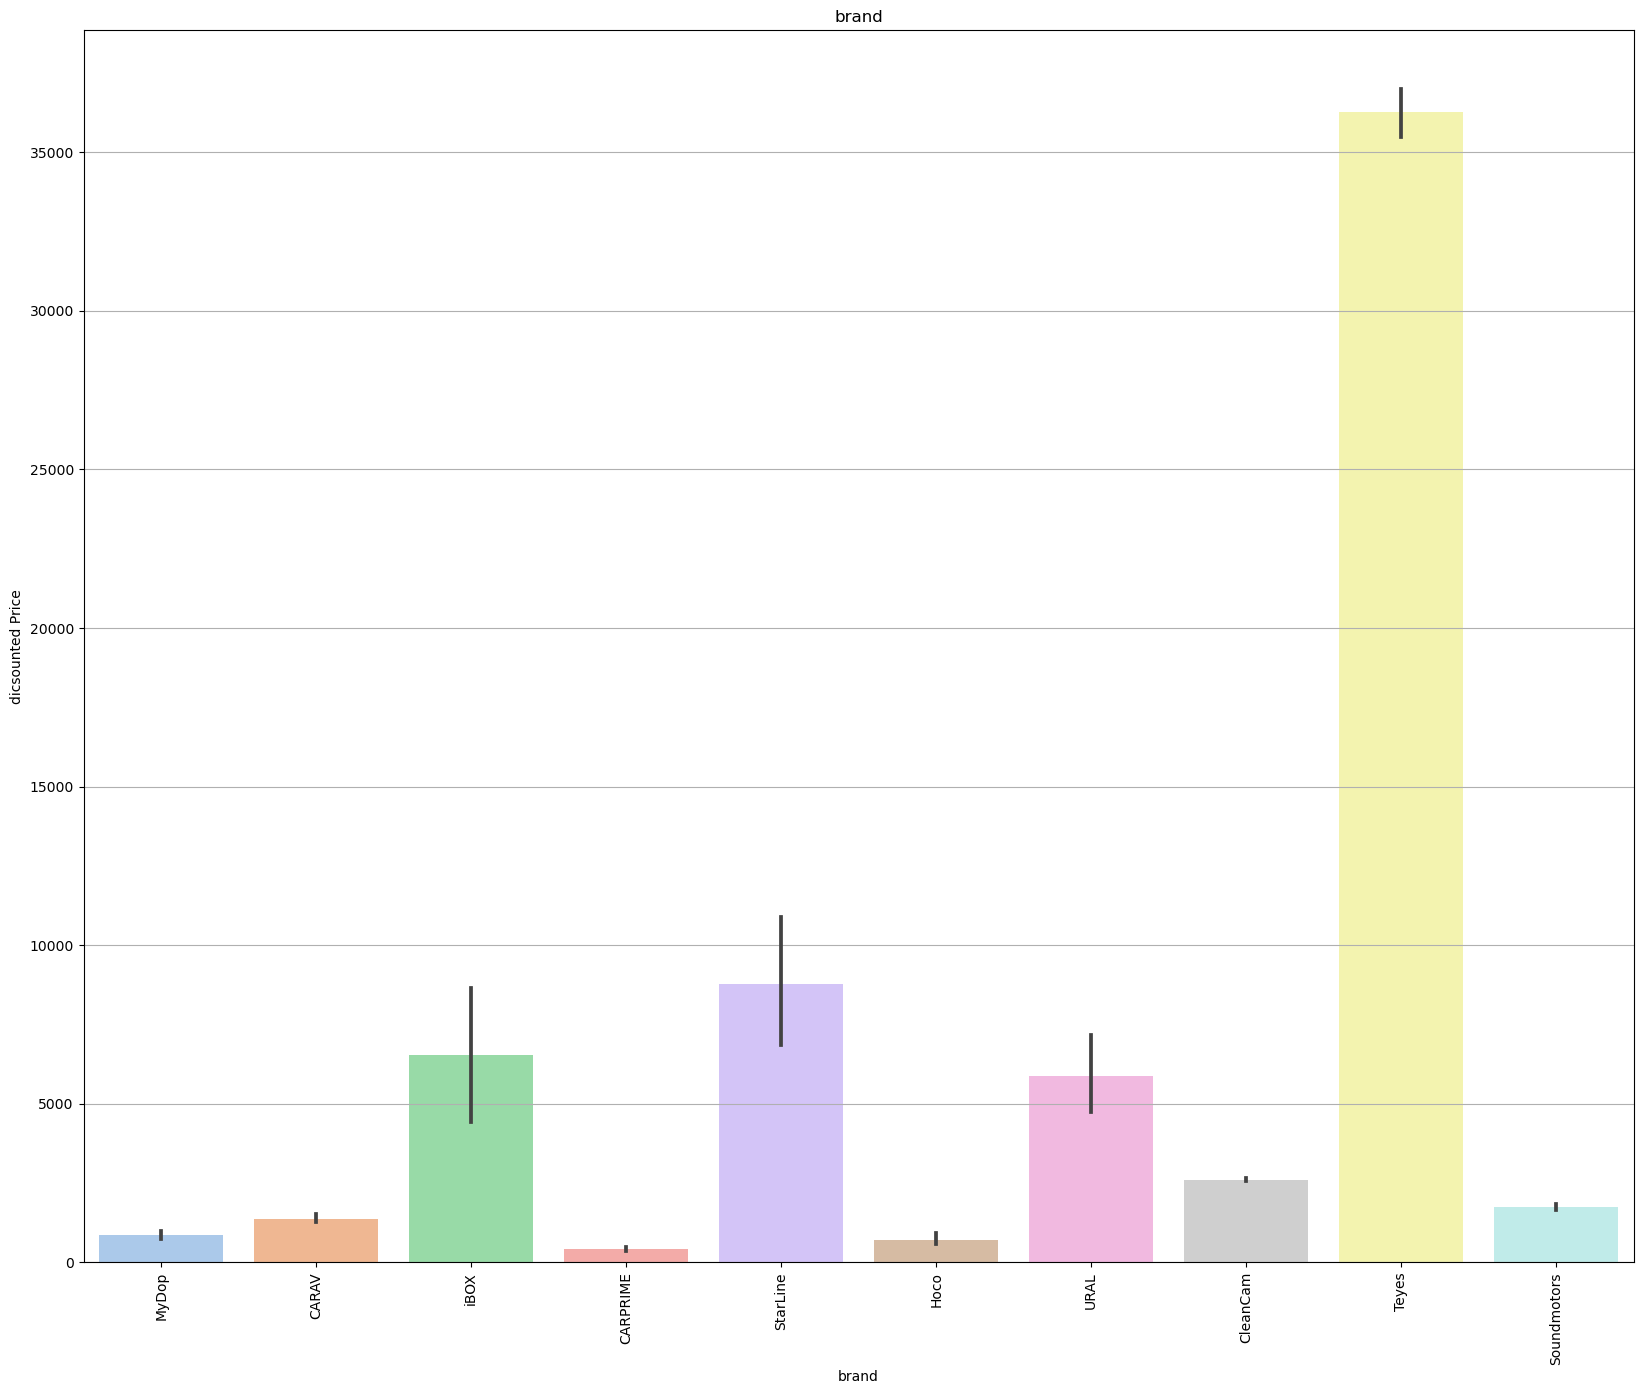

In [15]:
cat_graph(df2,CATEGORICAL_COLUMNS2)

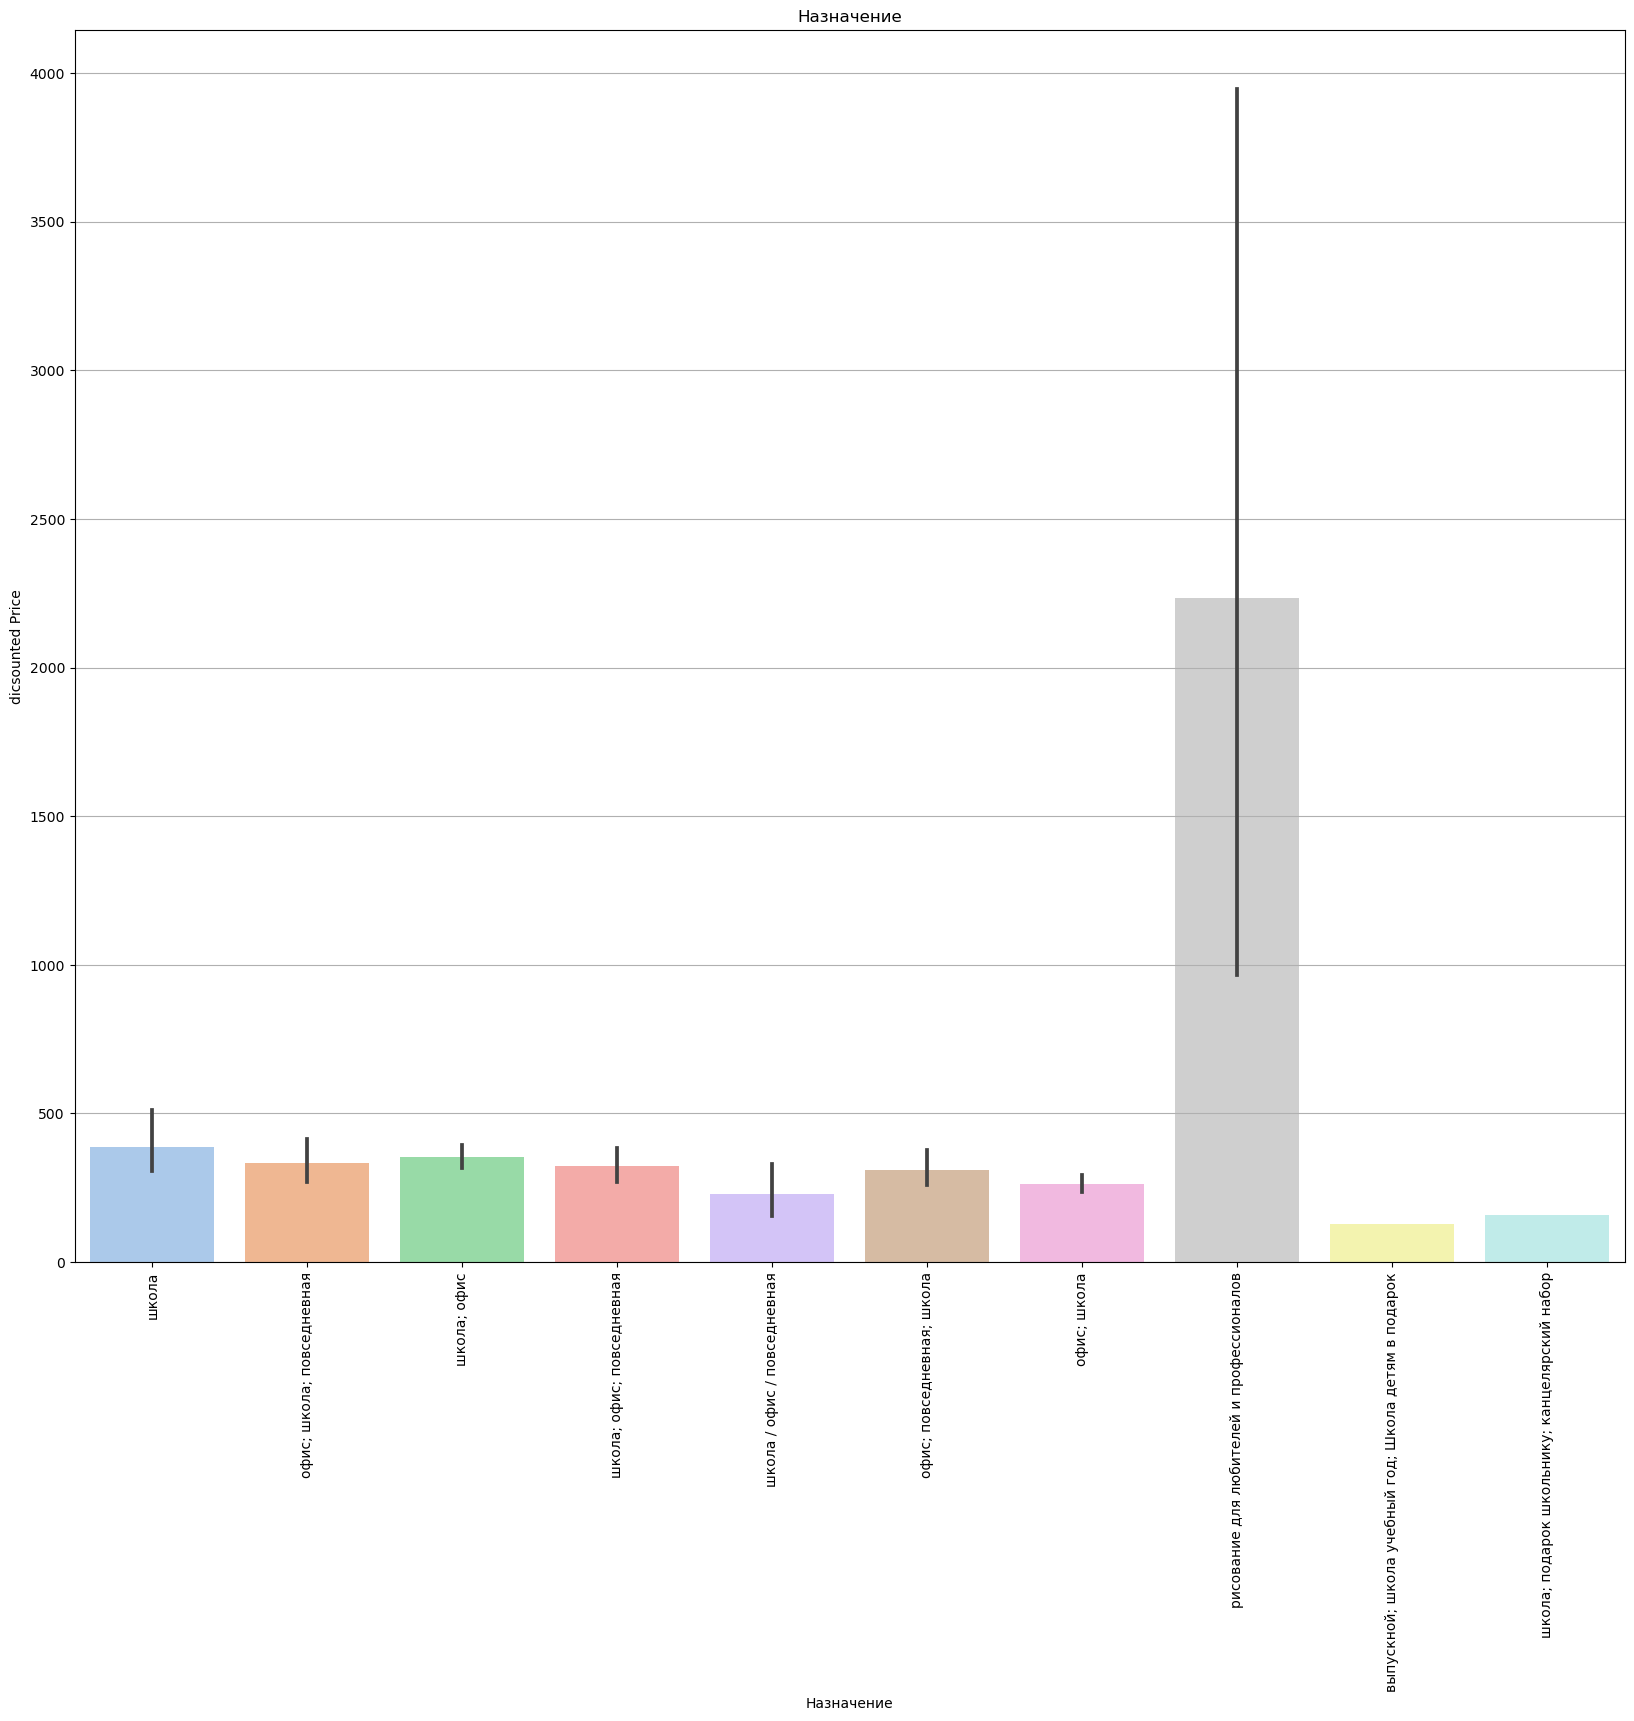

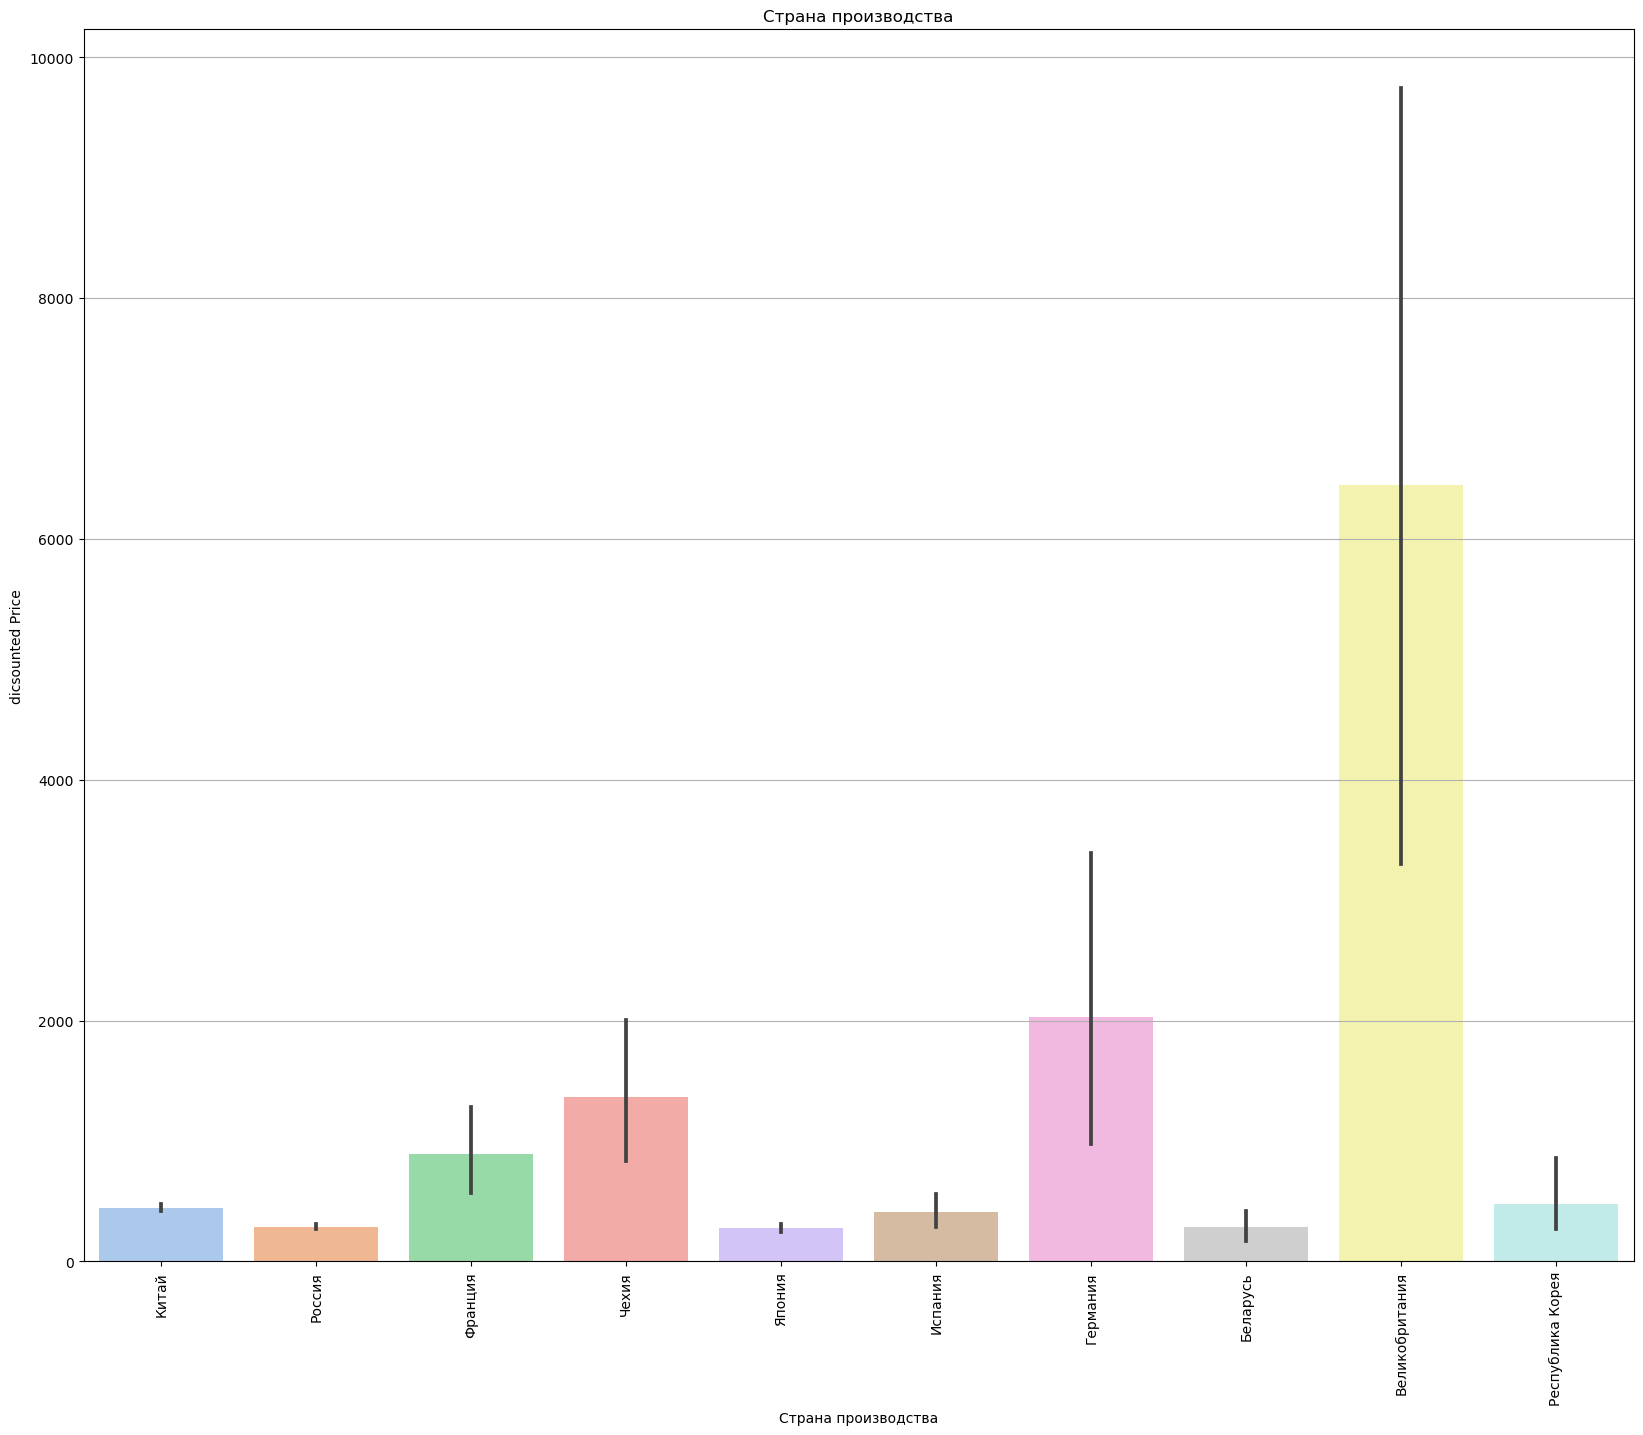

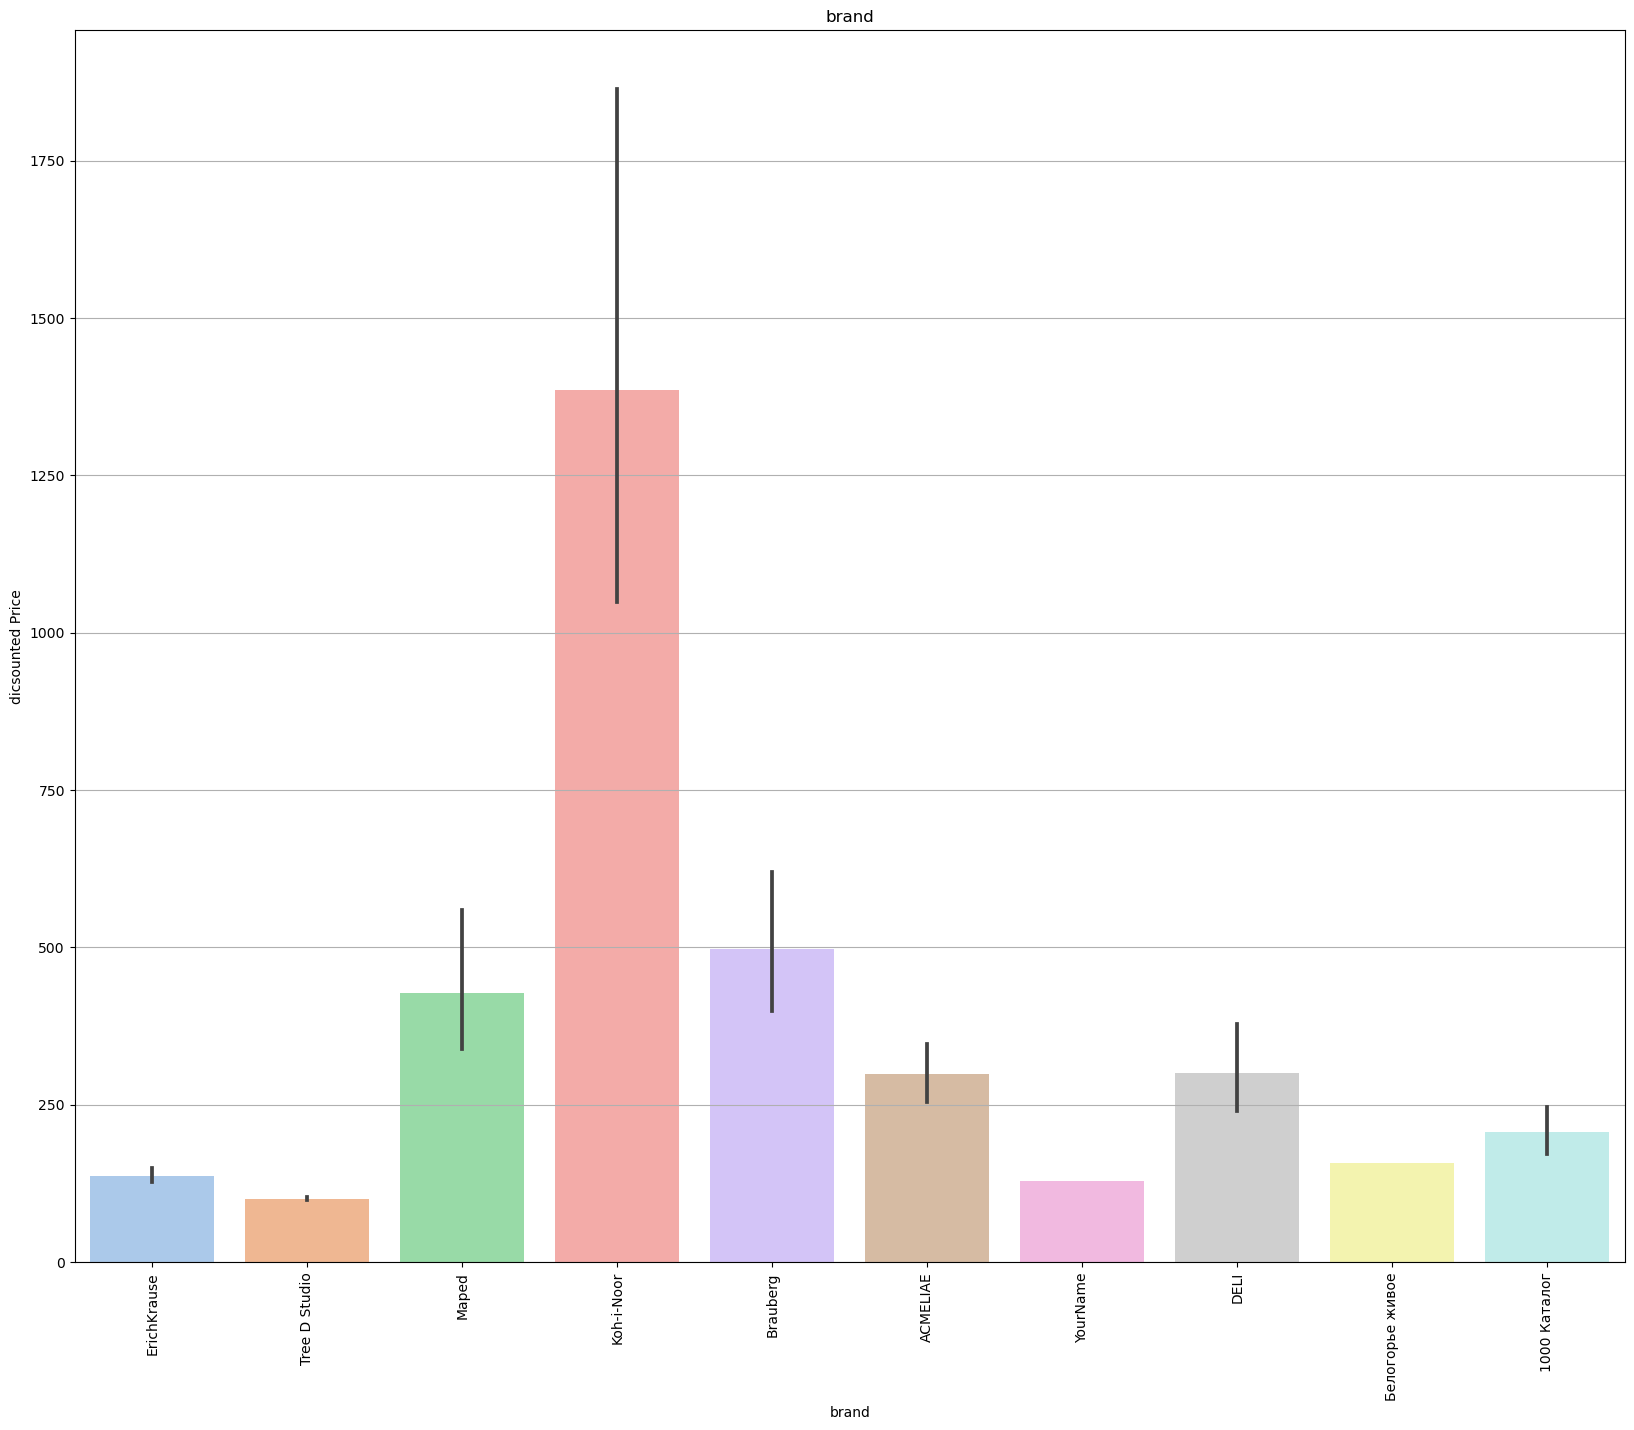

In [16]:
cat_graph(df3,CATEGORICAL_COLUMNS3)

In [17]:
def num_graphs(df,num_col):
    for val in df.columns:
            if val in num_col:
                plt.figure(figsize=(10, 8))
                sns.lineplot(data=df, x=val, y='dicsounted Price',palette='pastel')
                plt.xticks(rotation=90)
                plt.title(val, fontsize=12)
                plt.grid(True, axis='y')
                plt.show()

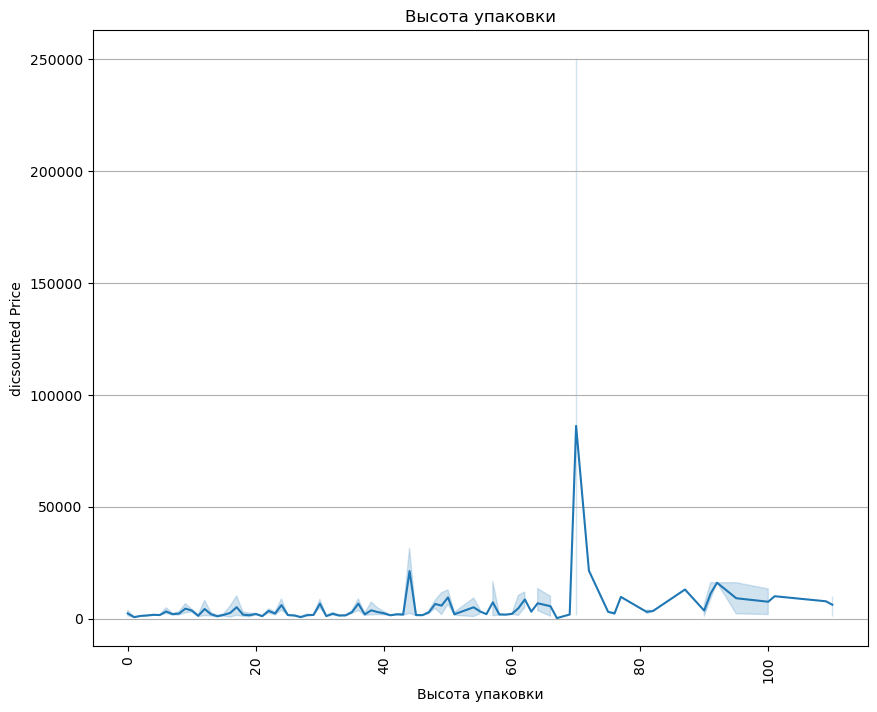

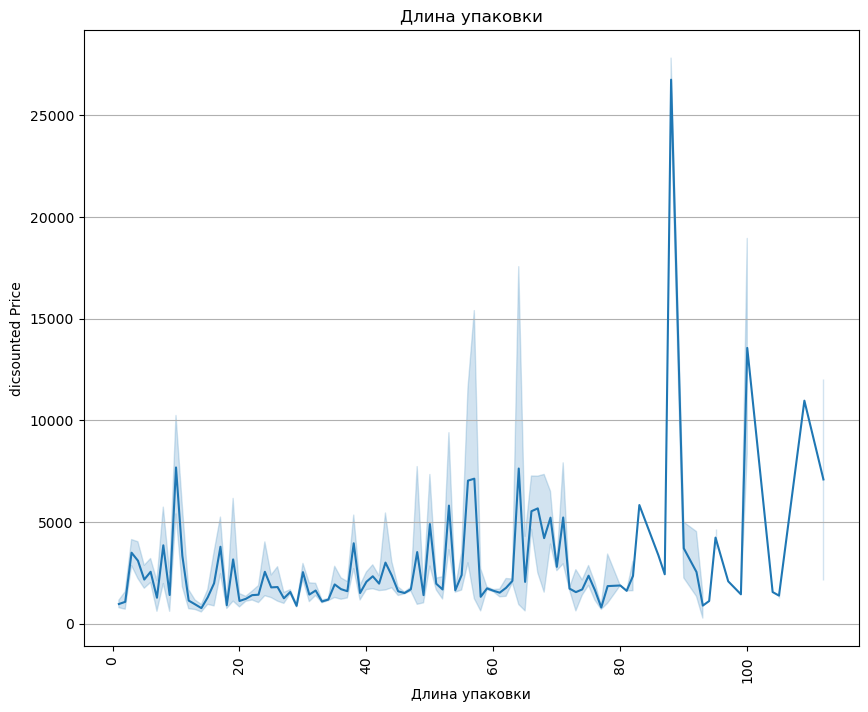

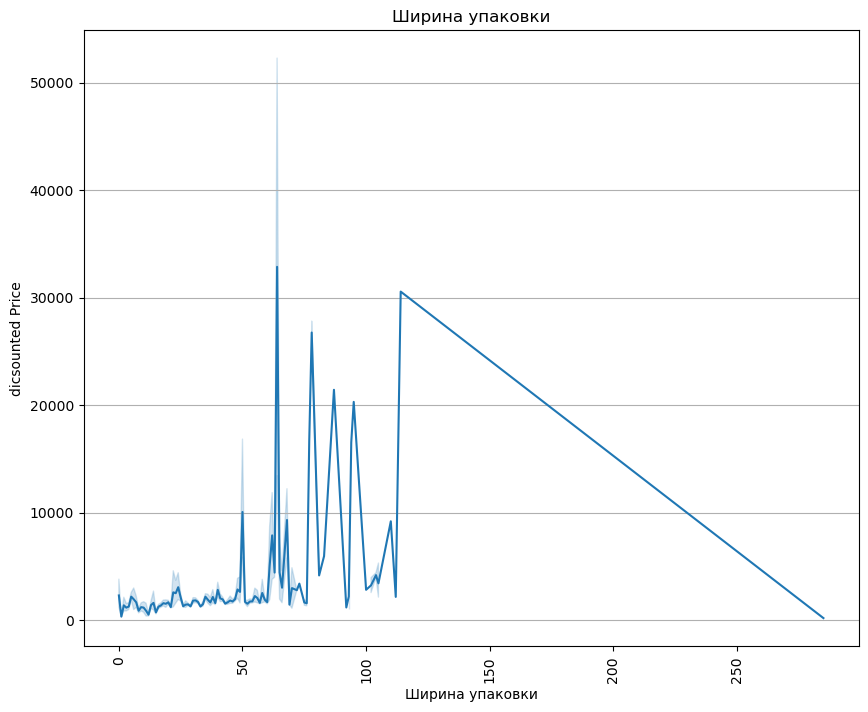

In [18]:
num_graphs(df1,NUMERIC_COLUMNS1)

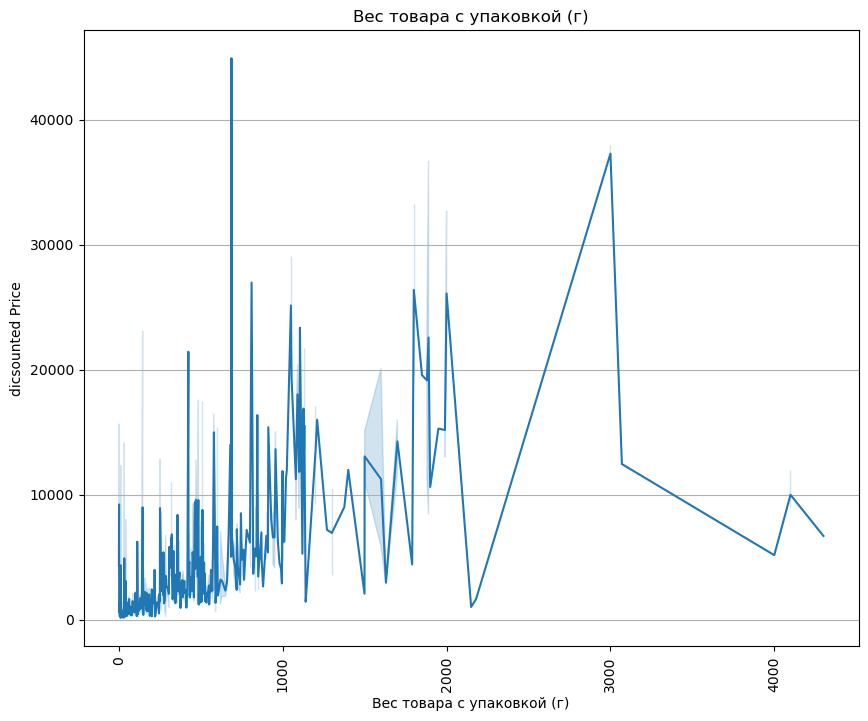

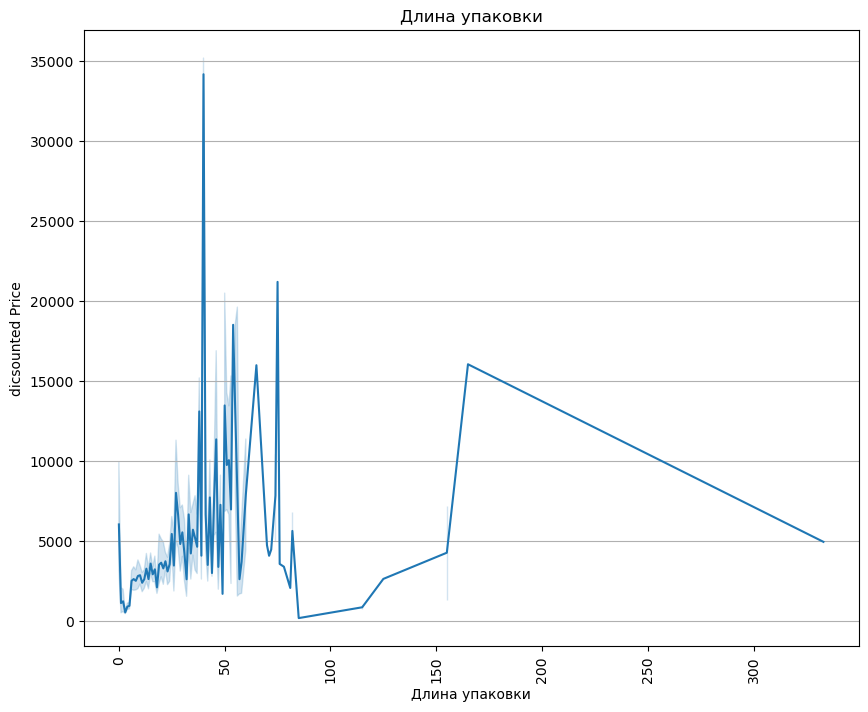

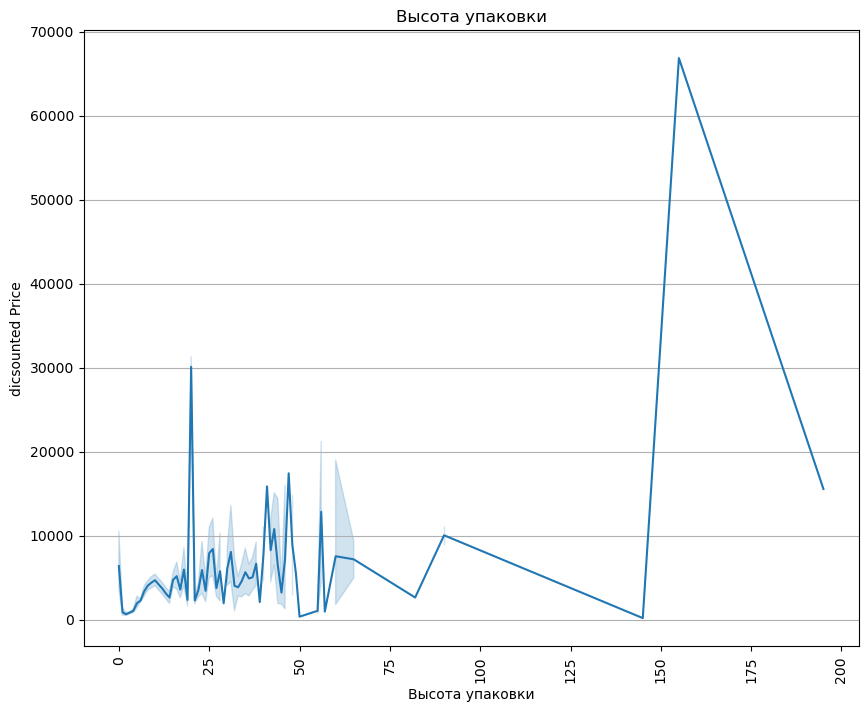

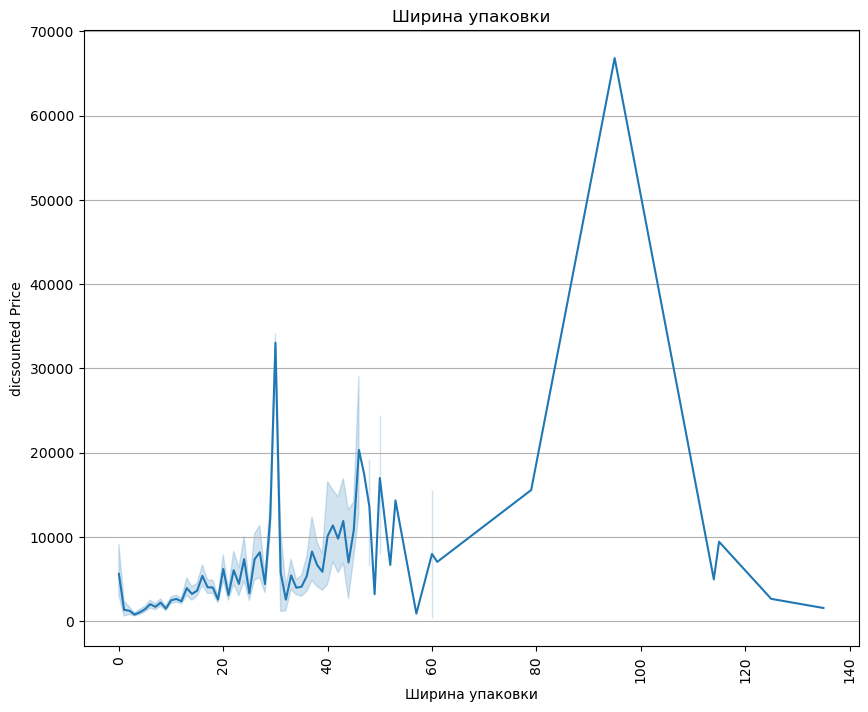

In [19]:
num_graphs(df2,NUMERIC_COLUMNS2)

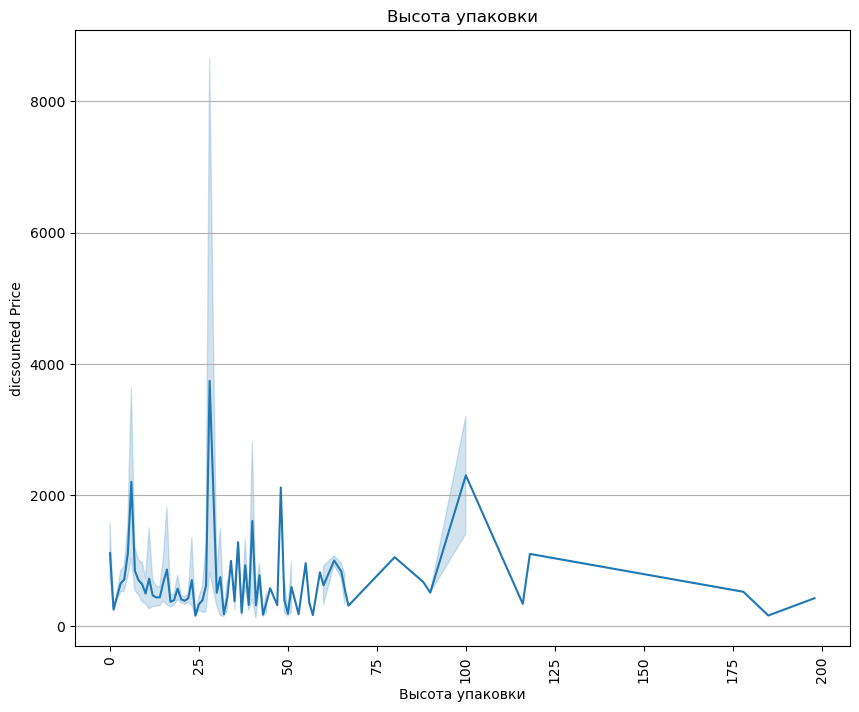

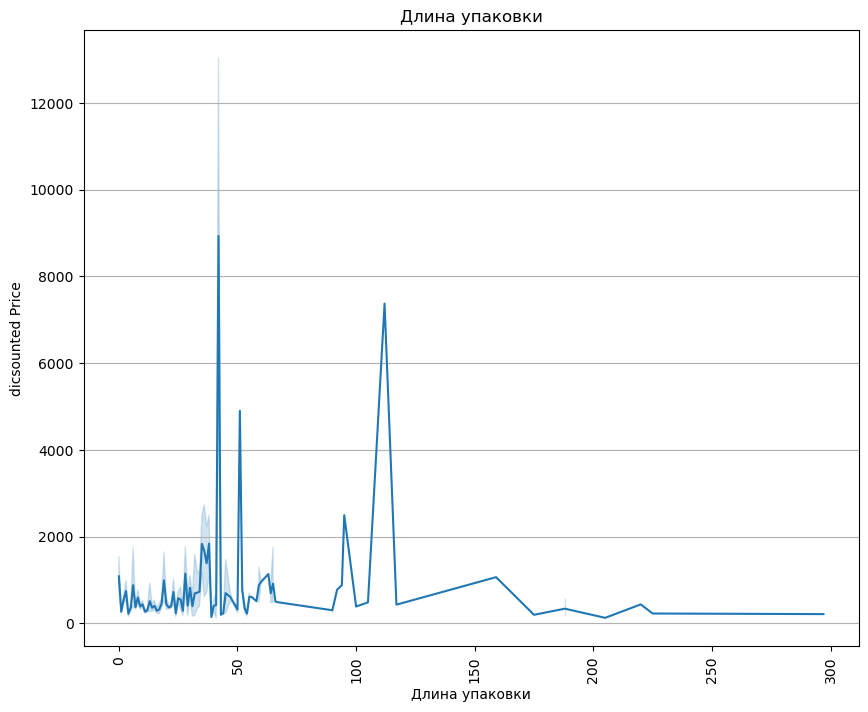

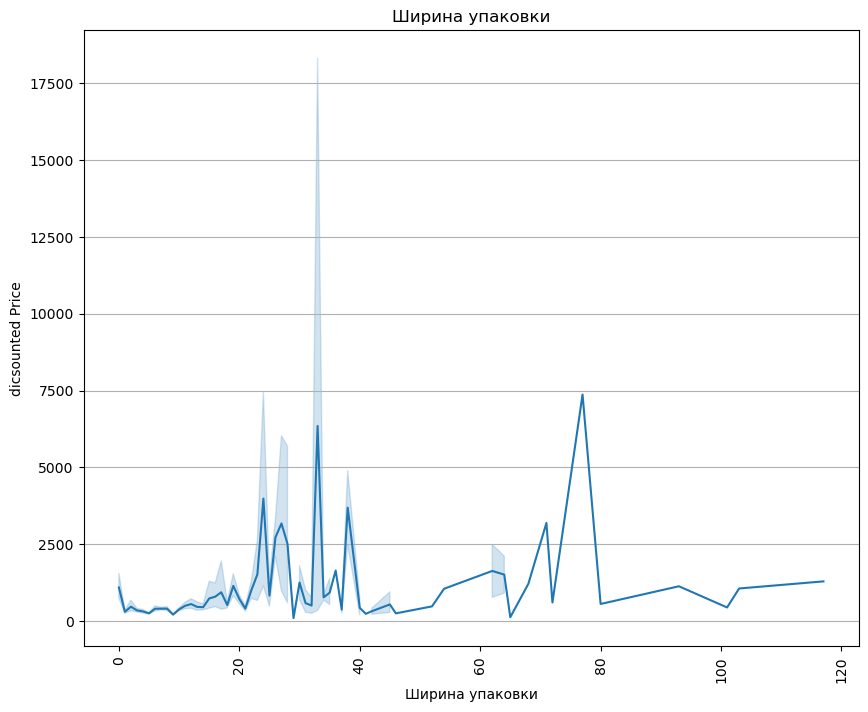

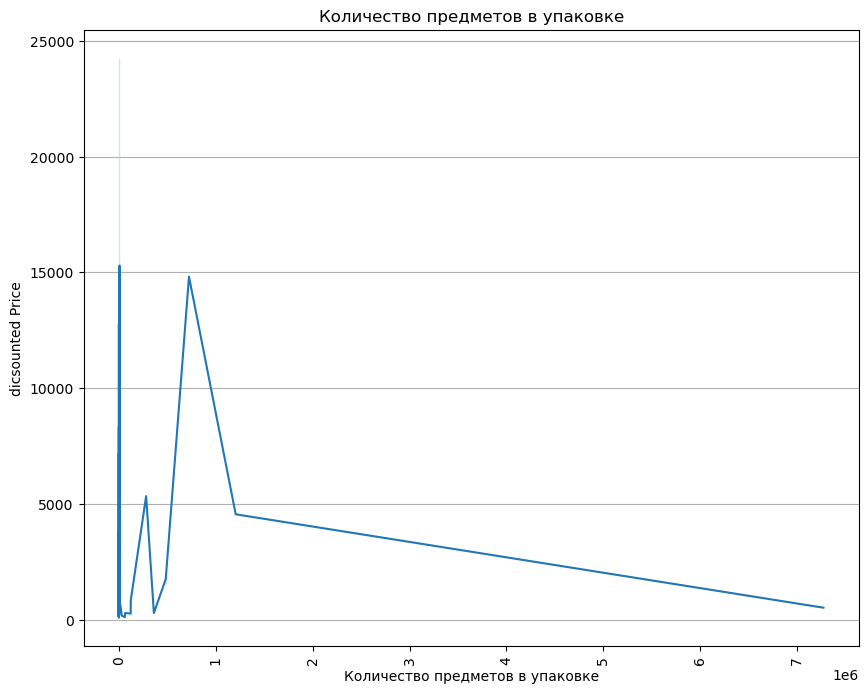

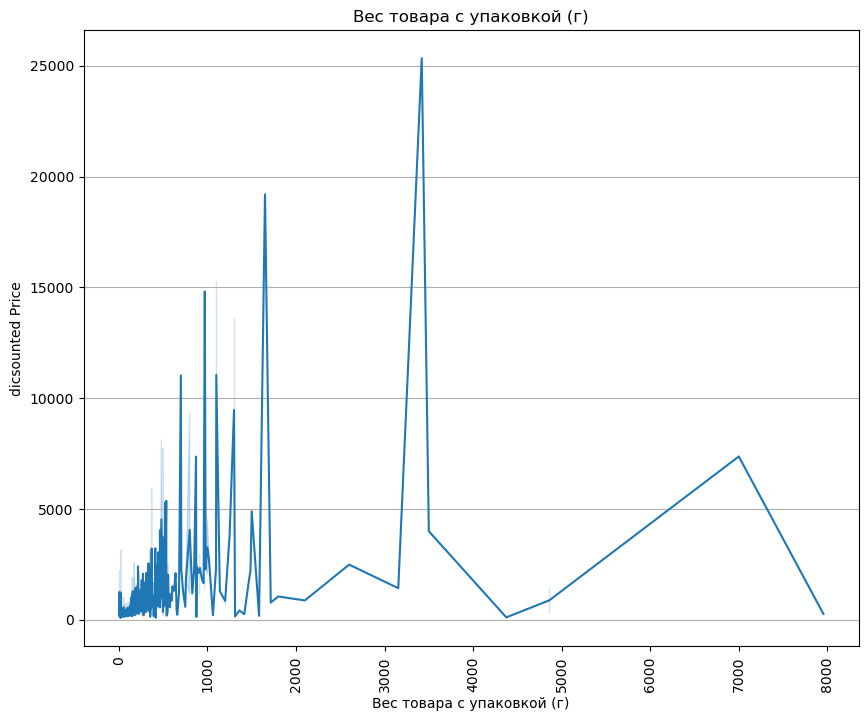

In [20]:
num_graphs(df3,NUMERIC_COLUMNS3)

In [21]:
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '',punctuation))

In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [23]:
reg = linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
en = linear_model.ElasticNet()
dtr = DecisionTreeRegressor()
xgb = XGBRegressor()
catb = ctb.CatBoostRegressor()

In [24]:
def pipeline(data: pd.DataFrame, categorical_features: list, numeric_features: list)-> pd.DataFrame:
    porter = PorterStemmer()

    #функция принимает данные и список категориальных колонок и преобразует их в числовые колнки
    oe = preprocessing.OrdinalEncoder()
    ss = preprocessing.RobustScaler()
    
    for feature in categorical_features:
        data[feature] = data[feature].replace(np.nan,'')
        data[feature] = data[feature].apply(remove_punctuation)
        data[feature] = data[feature].apply(porter.stem)

    data['Описание'] = data['Описание'].apply(remove_punctuation)
    data['Описание'] = data['Описание'].apply(porter.stem)
        
        
    for feature in numeric_features:
        percentile_90 = np.percentile(data[feature], 75)
        data[feature] = np.clip(data[feature], 0, percentile_90)
        data[feature] = ss.fit_transform(np.array(data[feature]).reshape((-1, 1)))
        data[feature] = data[feature].replace(np.nan,data[feature].mean())
        
    return data

In [25]:
df1 = pipeline(df1,CATEGORICAL_COLUMNS1,NUMERIC_COLUMNS1)

In [26]:
df2 = pipeline(df2,CATEGORICAL_COLUMNS2,NUMERIC_COLUMNS2)

In [27]:
df3 = pipeline(df3,CATEGORICAL_COLUMNS3,NUMERIC_COLUMNS3)

In [28]:
def get_basic_models_scores(model,X_train,y_train,X_test,y_test):
    
    #Возвращает значение MAPE для полученной модели
    mape = mean_absolute_percentage_error
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print(f'[RMSE:{rmse(y_pred,y_train)}]')
    print(f'[MAPE:{mean_absolute_percentage_error(y_pred,y_train)}]')

In [29]:
def get_cat_mat(df,CATEGORICAL_COLUMNS):
    cv = CountVectorizer(min_df=10)
    matrices = []
    for column in CATEGORICAL_COLUMNS:
        col_t = cv.fit_transform(df[column])
        matrices.append(col_t)
    cat_mat = hstack(matrices)
    return cat_mat
    

In [30]:
def get_desc_mat(df):
    tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2))
    desc_mat = tv.fit_transform(df['Описание'])
    return desc_mat

In [31]:
def reducecolumns(Col):
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [32]:
def get_full_mat(df,cat_mat,desc_mat,NUMERIC_COLUMNS):
    sparse_merge = hstack((reducecolumns(cat_mat), reducecolumns(desc_mat), df[NUMERIC_COLUMNS])).tocsr()
    return sparse_merge

In [33]:
def get_train_test(df,mat,TARGET='dicsounted Price',):
    features_train, features_test, target_train, target_test = train_test_split(mat, df[TARGET], test_size = .35, random_state = 1)
    return features_train, features_test, target_train, target_test

In [34]:
def get_split(df,NUMERIC_COLUMNS,CATEGORICAL_COLUMNS):
    df = pipeline(df,CATEGORICAL_COLUMNS,NUMERIC_COLUMNS)
    cat_mat = get_cat_mat(df,CATEGORICAL_COLUMNS)
    desc_mat = get_desc_mat(df)
    full_mat = get_full_mat(df,cat_mat,desc_mat,NUMERIC_COLUMNS)
    features_train, features_test, target_train, target_test = get_train_test(df,full_mat)
    return features_train, features_test, target_train, target_test

In [35]:
features_train1, features_test1, target_train1, target_test1 =  get_split(df1,NUMERIC_COLUMNS1,CATEGORICAL_COLUMNS1)

In [36]:
get_basic_models_scores(reg,features_train1,target_train1,features_train1,target_test1)

[RMSE:335.21334231337516]
[MAPE:0.11862902033049037]


In [37]:
get_basic_models_scores(ridge,features_train1,target_train1,features_train1,target_test1)

[RMSE:1940.9826383574152]
[MAPE:1.4178522576269494]


In [38]:
get_basic_models_scores(lasso,features_train1,target_train1,features_train1,target_test1)

[RMSE:1488.0541615689315]
[MAPE:0.800808206571312]


In [39]:
get_basic_models_scores(xgb,features_train1,target_train1,features_train1,target_test1)

[RMSE:325.6492163001904]
[MAPE:0.1315668048889286]


In [40]:
get_basic_models_scores(catb,features_train1,target_train1,features_train1,target_test1)

Learning rate set to 0.048935
0:	learn: 5155.3874775	total: 137ms	remaining: 2m 17s
1:	learn: 5109.0592634	total: 166ms	remaining: 1m 22s
2:	learn: 5063.2957131	total: 195ms	remaining: 1m 4s
3:	learn: 5018.4554767	total: 225ms	remaining: 55.9s
4:	learn: 4974.1867498	total: 254ms	remaining: 50.5s
5:	learn: 4930.6911039	total: 280ms	remaining: 46.4s
6:	learn: 4896.2610645	total: 307ms	remaining: 43.5s
7:	learn: 4853.5246553	total: 333ms	remaining: 41.3s
8:	learn: 4811.9244969	total: 359ms	remaining: 39.5s
9:	learn: 4771.0346437	total: 393ms	remaining: 38.9s
10:	learn: 4730.7901156	total: 422ms	remaining: 38s
11:	learn: 4690.9484368	total: 454ms	remaining: 37.3s
12:	learn: 4651.9814926	total: 484ms	remaining: 36.7s
13:	learn: 4612.6213935	total: 511ms	remaining: 36s
14:	learn: 4574.9303758	total: 539ms	remaining: 35.4s
15:	learn: 4545.2535859	total: 567ms	remaining: 34.9s
16:	learn: 4508.6715689	total: 595ms	remaining: 34.4s
17:	learn: 4472.6844232	total: 641ms	remaining: 35s
18:	learn: 4

In [41]:
def get_split(df,NUMERIC_COLUMNS,CATEGORICAL_COLUMNS):
    df = pipeline(df,CATEGORICAL_COLUMNS,NUMERIC_COLUMNS)
    cat_mat = get_cat_mat(df,CATEGORICAL_COLUMNS)
    desc_mat = get_desc_mat(df)
    full_mat = get_full_mat(df,cat_mat,desc_mat,NUMERIC_COLUMNS)
    features_train, features_test, target_train, target_test = get_train_test(df,full_mat)
    return features_train, features_test, target_train, target_test
    

In [42]:
features_train2, features_test2, target_train2, target_test2 = get_split(df2,NUMERIC_COLUMNS2,CATEGORICAL_COLUMNS2)

In [43]:
get_basic_models_scores(reg,features_train2,target_train2,features_train2,target_test2)

[RMSE:2114.9960087980435]
[MAPE:0.03466991163049593]


In [44]:
get_basic_models_scores(ridge,features_train2,target_train2,features_train2,target_test2)

[RMSE:3024.9111029534865]
[MAPE:0.909704121935713]


In [45]:
get_basic_models_scores(lasso,features_train2,target_train2,features_train2,target_test2)

[RMSE:3046.3028496346797]
[MAPE:1.207979475365739]


In [46]:
get_basic_models_scores(xgb,features_train2,target_train2,features_train2,target_test2)

[RMSE:2165.7843063133896]
[MAPE:0.38204837912229933]


In [47]:
get_basic_models_scores(catb,features_train2,target_train2,features_train2,target_test2)

Learning rate set to 0.048014
0:	learn: 11642.0864672	total: 164ms	remaining: 2m 43s
1:	learn: 11221.9284825	total: 228ms	remaining: 1m 53s
2:	learn: 10850.1762140	total: 288ms	remaining: 1m 35s
3:	learn: 10497.9011284	total: 347ms	remaining: 1m 26s
4:	learn: 10166.9748742	total: 406ms	remaining: 1m 20s
5:	learn: 9858.6355423	total: 470ms	remaining: 1m 17s
6:	learn: 9546.8880944	total: 529ms	remaining: 1m 15s
7:	learn: 9272.1846152	total: 589ms	remaining: 1m 13s
8:	learn: 8988.0528040	total: 648ms	remaining: 1m 11s
9:	learn: 8732.7219084	total: 707ms	remaining: 1m 9s
10:	learn: 8502.4360211	total: 766ms	remaining: 1m 8s
11:	learn: 8278.9592549	total: 825ms	remaining: 1m 7s
12:	learn: 8064.0612474	total: 885ms	remaining: 1m 7s
13:	learn: 7860.9171043	total: 957ms	remaining: 1m 7s
14:	learn: 7658.1021390	total: 1.02s	remaining: 1m 6s
15:	learn: 7484.1369902	total: 1.07s	remaining: 1m 6s
16:	learn: 7316.2970627	total: 1.14s	remaining: 1m 5s
17:	learn: 7147.5509327	total: 1.2s	remaining: 1

In [48]:
features_train3, features_test3, target_train3, target_test3 = get_split(df3,NUMERIC_COLUMNS3,CATEGORICAL_COLUMNS3)

In [49]:
get_basic_models_scores(reg,features_train3,target_train3,features_train3,target_test3)

[RMSE:127.62225996481916]
[MAPE:0.13996402356124565]


In [50]:
get_basic_models_scores(ridge,features_train3,target_train3,features_train3,target_test3)

[RMSE:581.9248724991601]
[MAPE:1.284622399375078]


In [51]:
get_basic_models_scores(lasso,features_train3,target_train3,features_train3,target_test3)

[RMSE:832.9074411471246]
[MAPE:1.1028965734407539]


In [52]:
get_basic_models_scores(xgb,features_train3,target_train3,features_train3,target_test3)

[RMSE:95.04842061761967]
[MAPE:0.18383747290074323]


In [53]:
get_basic_models_scores(catb,features_train3,target_train3,features_train3,target_test3)

Learning rate set to 0.046788
0:	learn: 1101.5891176	total: 77.8ms	remaining: 1m 17s
1:	learn: 1093.6012575	total: 133ms	remaining: 1m 6s
2:	learn: 1085.9634894	total: 181ms	remaining: 1m
3:	learn: 1078.4218770	total: 224ms	remaining: 55.8s
4:	learn: 1070.4701308	total: 266ms	remaining: 52.9s
5:	learn: 1060.7520556	total: 308ms	remaining: 51.1s
6:	learn: 1054.3602027	total: 349ms	remaining: 49.6s
7:	learn: 1047.8678789	total: 393ms	remaining: 48.7s
8:	learn: 1040.9193140	total: 439ms	remaining: 48.3s
9:	learn: 1034.1088400	total: 485ms	remaining: 48s
10:	learn: 1028.0901617	total: 537ms	remaining: 48.3s
11:	learn: 1021.4782192	total: 591ms	remaining: 48.7s
12:	learn: 1014.1860222	total: 645ms	remaining: 49s
13:	learn: 1007.5215009	total: 700ms	remaining: 49.3s
14:	learn: 1001.1536471	total: 745ms	remaining: 48.9s
15:	learn: 995.4721944	total: 788ms	remaining: 48.5s
16:	learn: 989.0865017	total: 832ms	remaining: 48.1s
17:	learn: 982.2180789	total: 877ms	remaining: 47.8s
18:	learn: 976.4